In [1]:
from __future__ import absolute_import
from __future__ import print_function
import matplotlib.pyplot as plt

import jax.numpy as np
import numpy.random as npr
from jax import grad, jit, vmap
import jax.scipy.stats.norm as norm
import jax.scipy.stats.multivariate_normal as mvn
# import jax.scipy.special import logsumexp
from jax import random
key = random.PRNGKey(758493)  # Random seed is explicit in JAX



In [7]:
import optax
optax.adam

<function optax._src.alias.adam(learning_rate: Union[float, Callable[[Union[jax._src.basearray.Array, float, int]], Union[jax._src.basearray.Array, float, int]]], b1: float = 0.9, b2: float = 0.999, eps: float = 1e-08, eps_root: float = 0.0, mu_dtype: Optional[Any] = None) -> optax._src.base.GradientTransformation>

In [2]:

def adam(grad, x, callback=None, num_iters=100,
         step_size=0.001, b1=0.9, b2=0.999, eps=10**-8):
    m = np.zeros(len(x))
    v = np.zeros(len(x))
    for i in range(num_iters):
        g = grad(x, i)
        callback(x, i, g)

        m = (1 - b1) * g + b1 * m  # First  moment estimate.
        v = (1 - b2) * (g**2) + b2 * v  # Second moment estimate.
        mhat = m / (1 - b1**(i + 1))    # Bias correction.
        vhat = v / (1 - b2**(i + 1))
        x = x - step_size*mhat/(np.sqrt(vhat) + eps)

    return x


In [3]:
for i in plt.get_fignums():
    plt.figure(i)
    plt.savefig('figure%d.png' % i)

In [4]:
plt.get_fignums()

[]

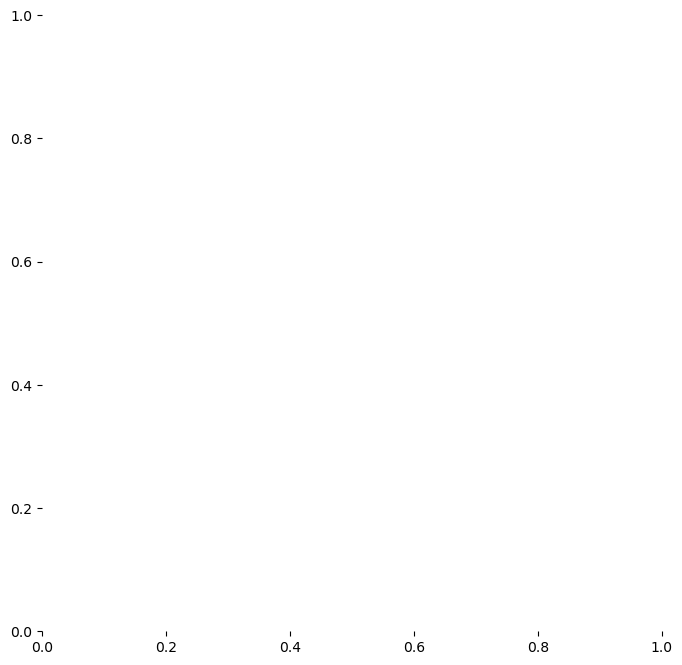

Optimizing variational parameters...
Iteration 0 lower bound -8.269590377807617
(10201,)
Iteration 1 lower bound -6.871846675872803
(10201,)
Iteration 2 lower bound -5.878347396850586
(10201,)
Iteration 3 lower bound -5.1665143966674805
(10201,)
Iteration 4 lower bound -4.647826194763184
(10201,)
Iteration 5 lower bound -4.255313873291016
(10201,)
Iteration 6 lower bound -3.9424853324890137
(10201,)
Iteration 7 lower bound -3.6810717582702637
(10201,)
Iteration 8 lower bound -3.450861930847168
(10201,)
Iteration 9 lower bound -3.2375354766845703
(10201,)
Iteration 10 lower bound -3.035890579223633
(10201,)
Iteration 11 lower bound -2.838010787963867
(10201,)
Iteration 12 lower bound -2.642362594604492
(10201,)
Iteration 13 lower bound -2.4480457305908203
(10201,)
Iteration 14 lower bound -2.251657485961914
(10201,)
Iteration 15 lower bound -2.05423641204834
(10201,)
Iteration 16 lower bound -1.8539620637893677
(10201,)
Iteration 17 lower bound -1.6521497964859009
(10201,)
Iteration 18 

/tmp/ipykernel_438086/4248734205.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Iteration 20 lower bound -1.0355581045150757
(10201,)
Iteration 21 lower bound -0.8272418975830078
(10201,)
Iteration 22 lower bound -0.6199626922607422
(10201,)
Iteration 23 lower bound -0.40832364559173584
(10201,)
Iteration 24 lower bound -0.19414925575256348
(10201,)
Iteration 25 lower bound 0.016646623611450195
(10201,)
Iteration 26 lower bound 0.2313443422317505
(10201,)
Iteration 27 lower bound 0.44796156883239746
(10201,)
Iteration 28 lower bound 0.6628202199935913
(10201,)
Iteration 29 lower bound 0.8782120943069458
(10201,)
Iteration 30 lower bound 1.0953493118286133
(10201,)
Iteration 31 lower bound 1.3043851852416992
(10201,)
Iteration 32 lower bound 1.5185730457305908
(10201,)
Iteration 33 lower bound 1.7233506441116333
(10201,)
Iteration 34 lower bound 1.9279886484146118
(10201,)
Iteration 35 lower bound 2.1221132278442383
(10201,)
Iteration 36 lower bound 2.2985010147094727
(10201,)
Iteration 37 lower bound 2.466024160385132
(10201,)
Iteration 38 lower bound 2.5941958427

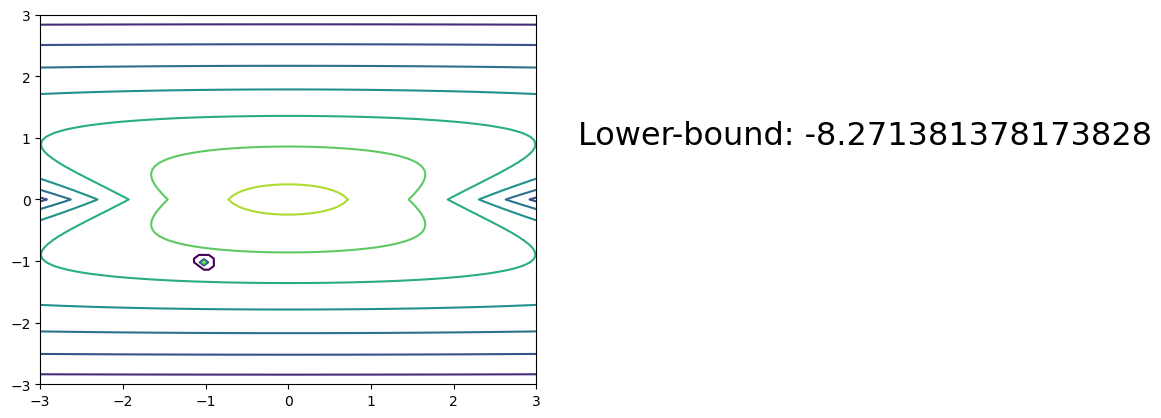

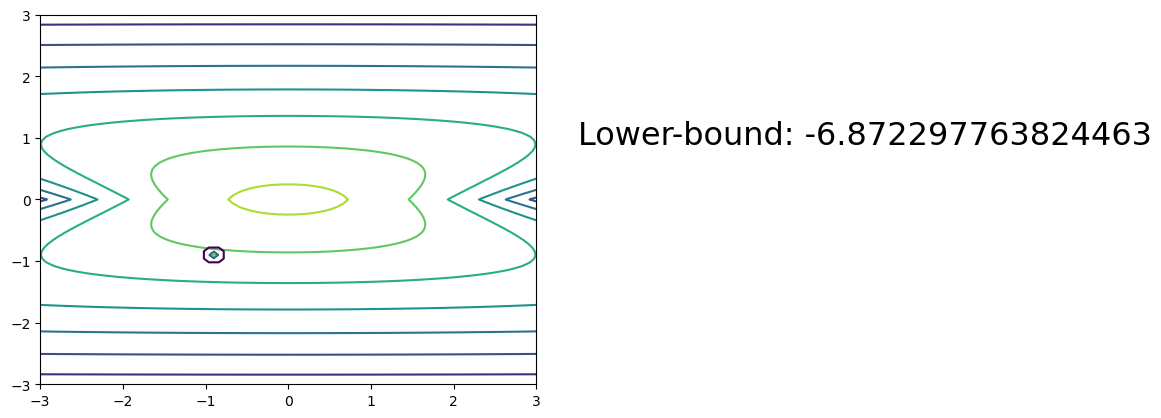

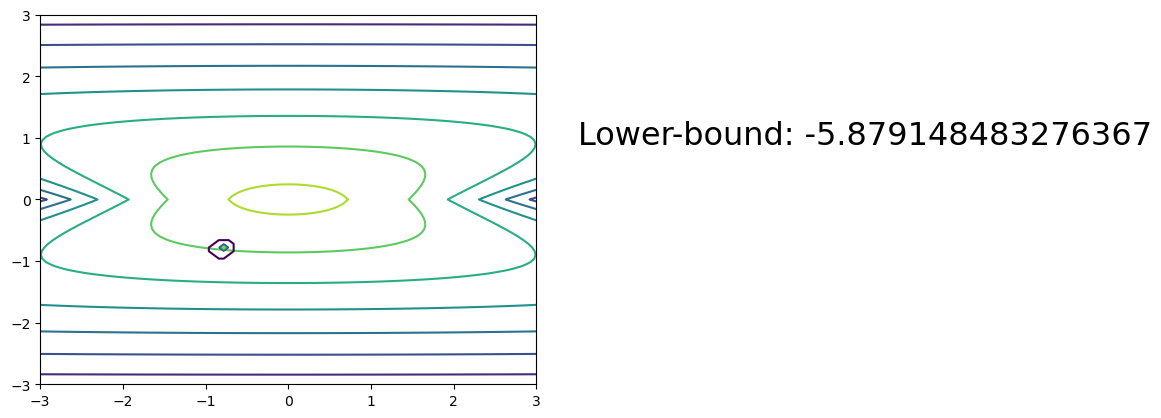

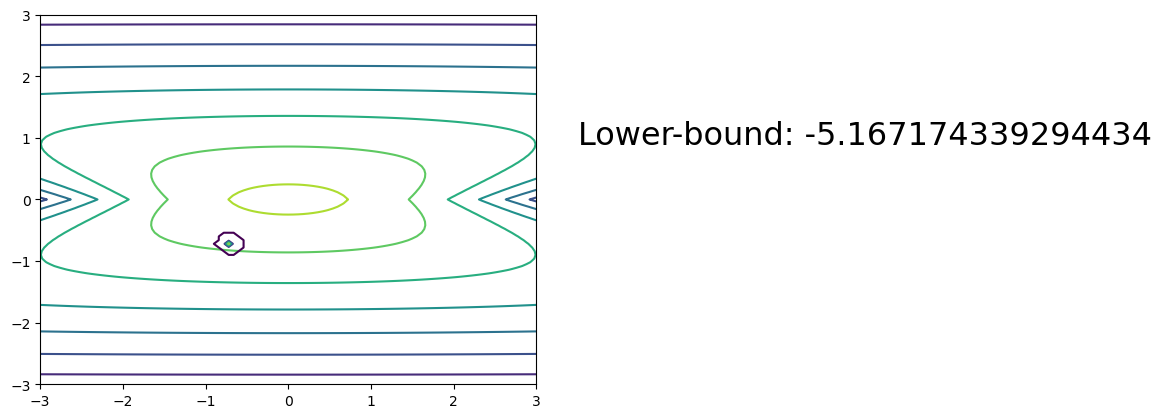

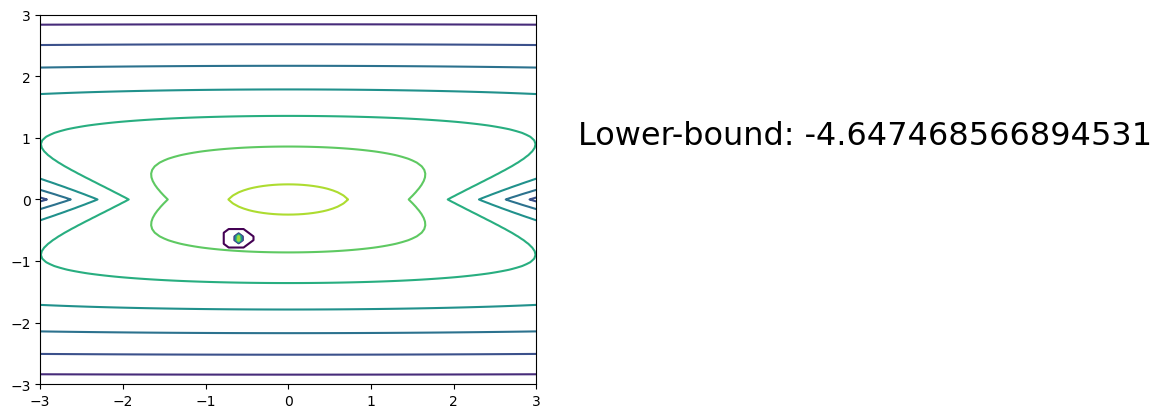

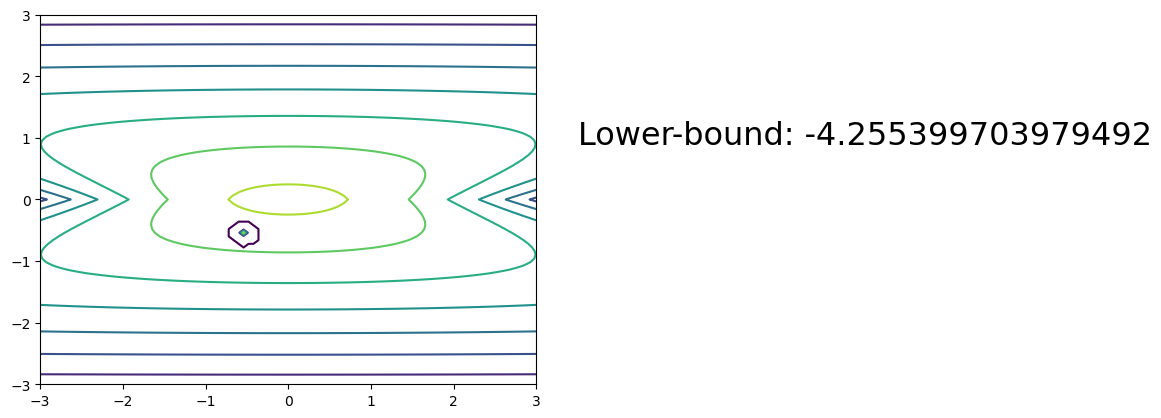

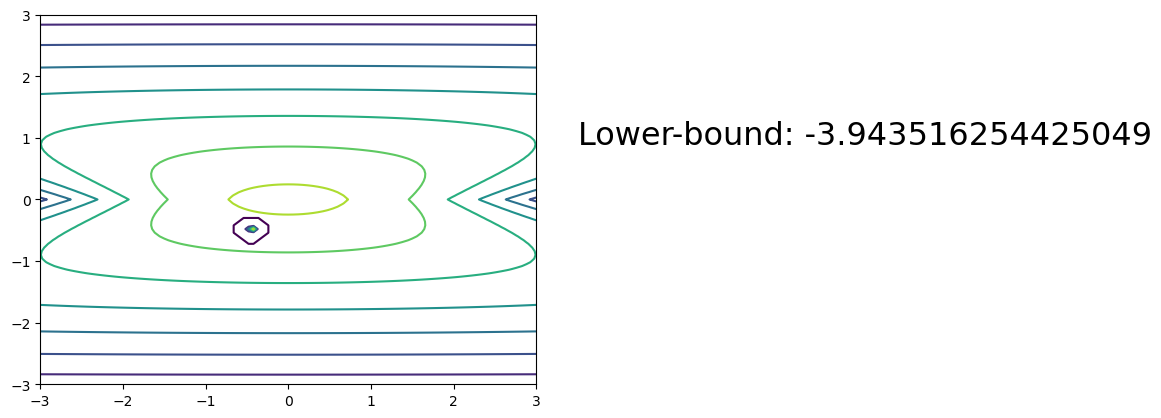

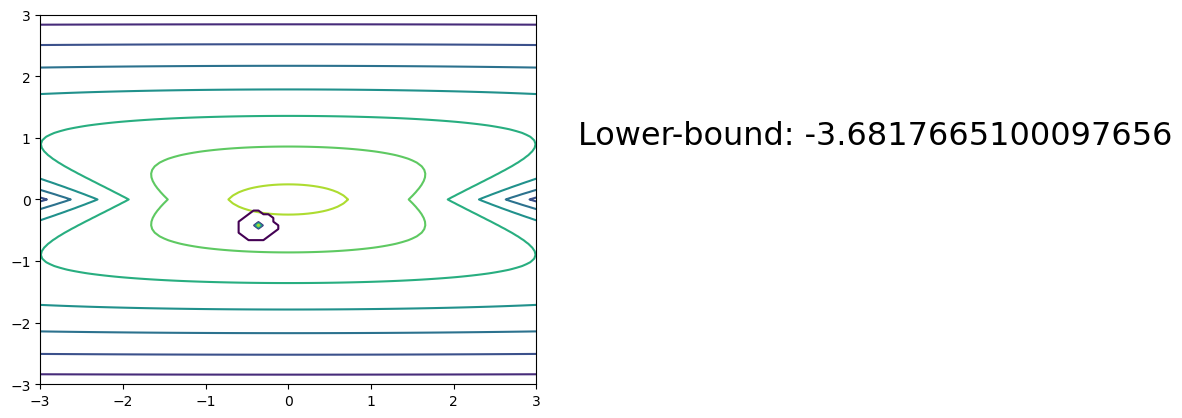

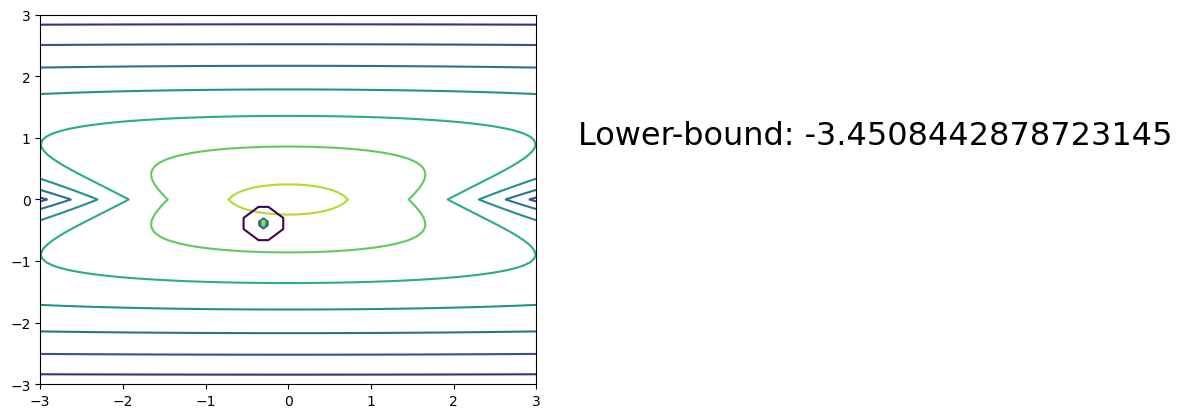

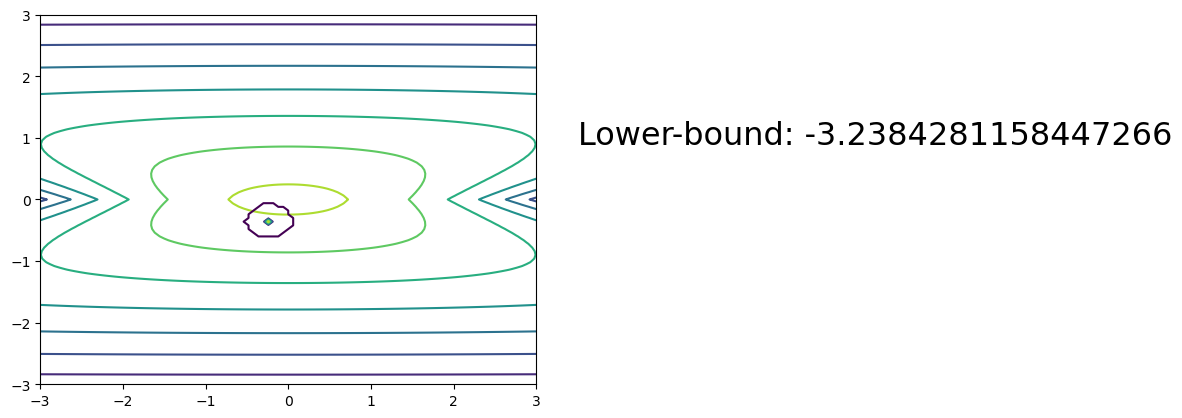

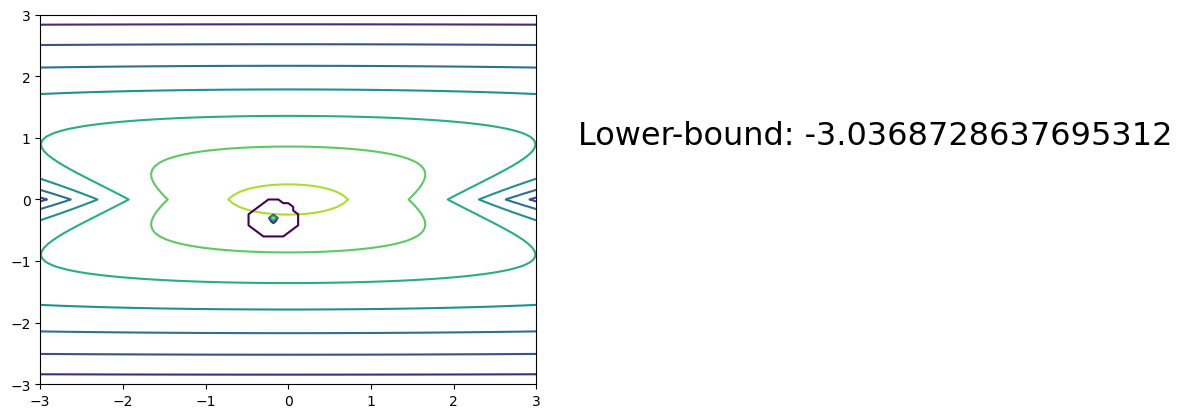

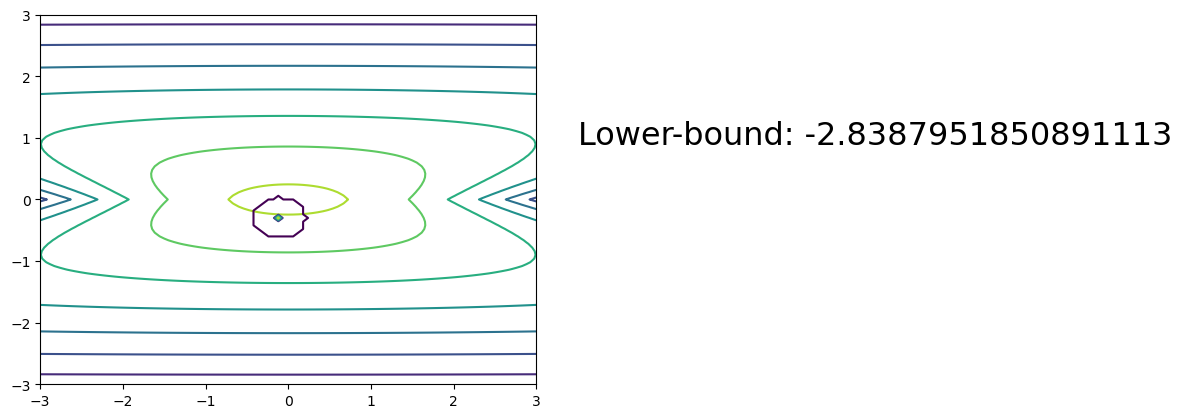

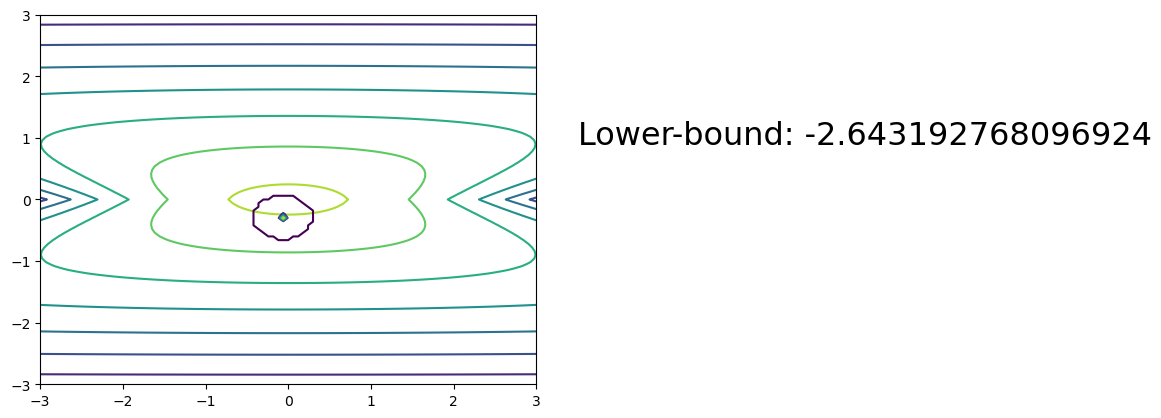

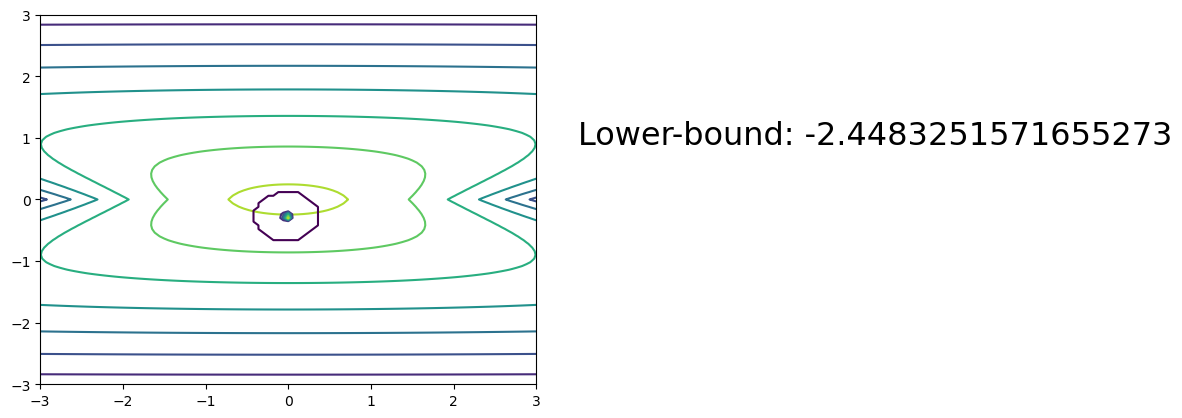

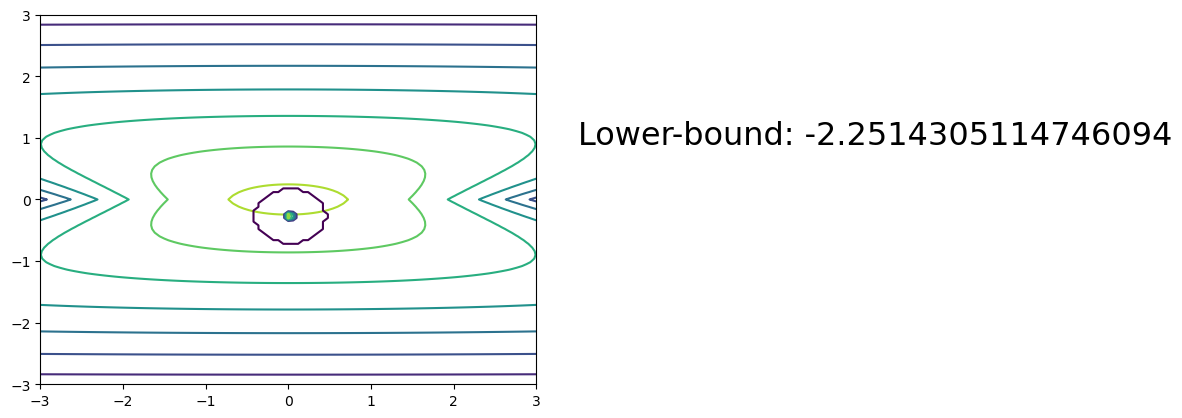

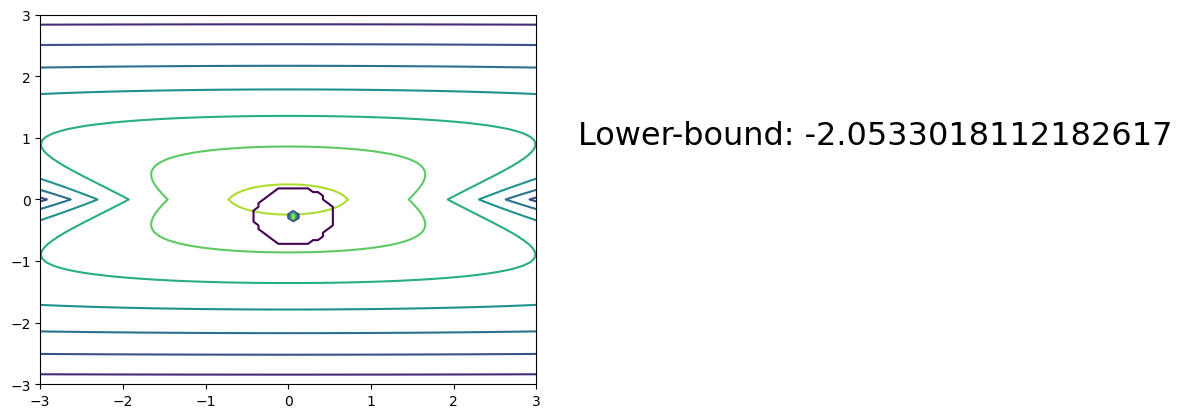

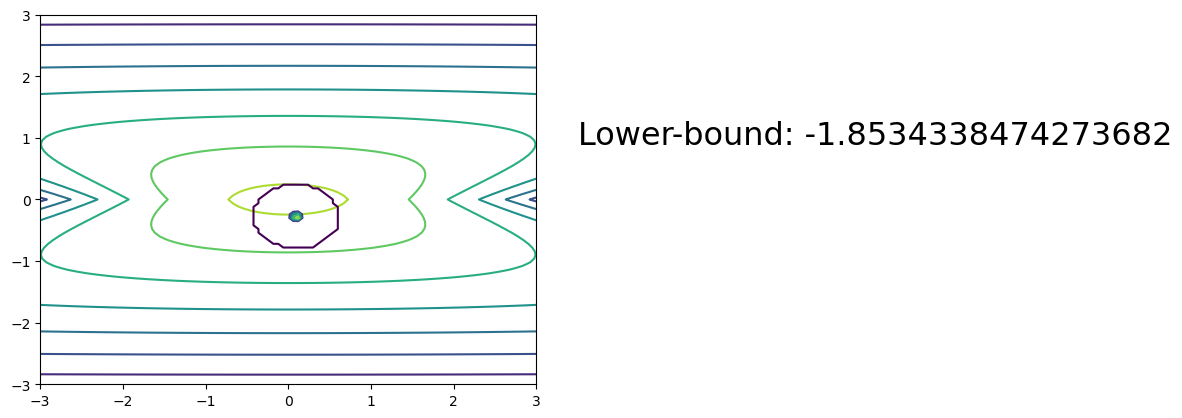

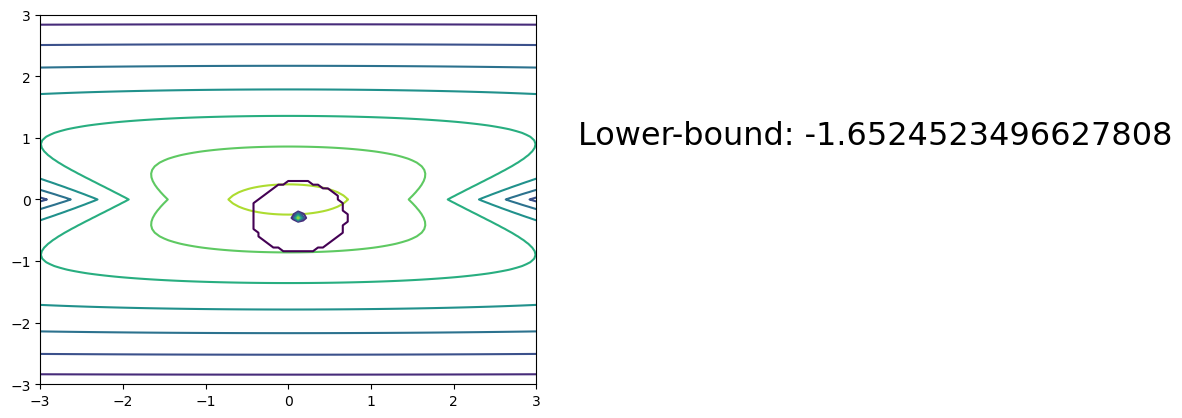

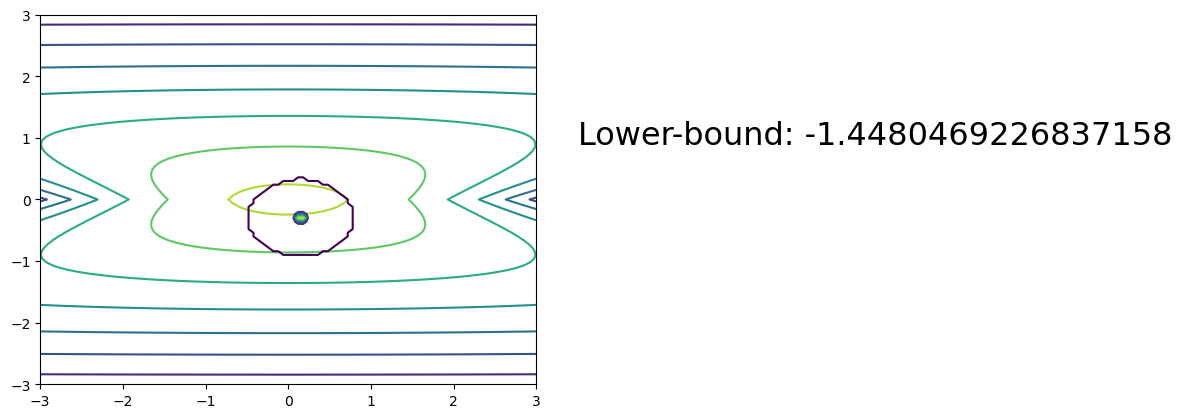

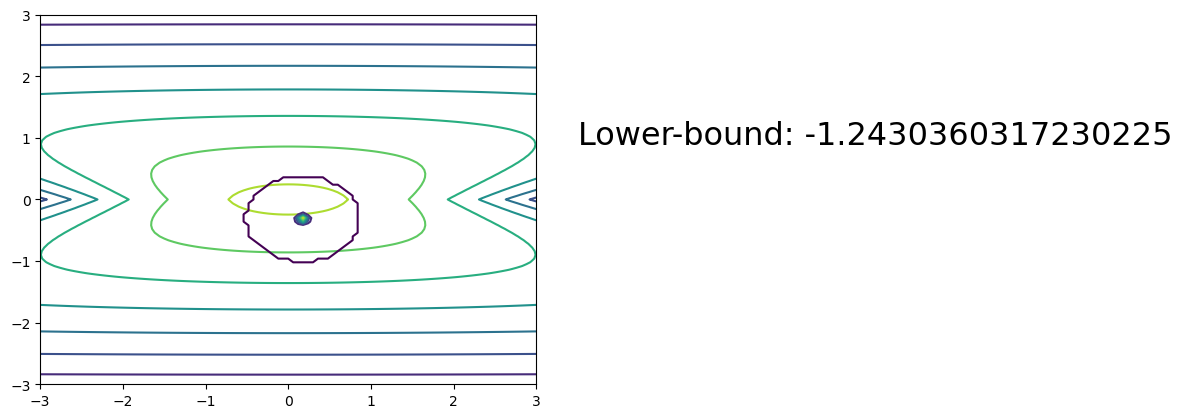

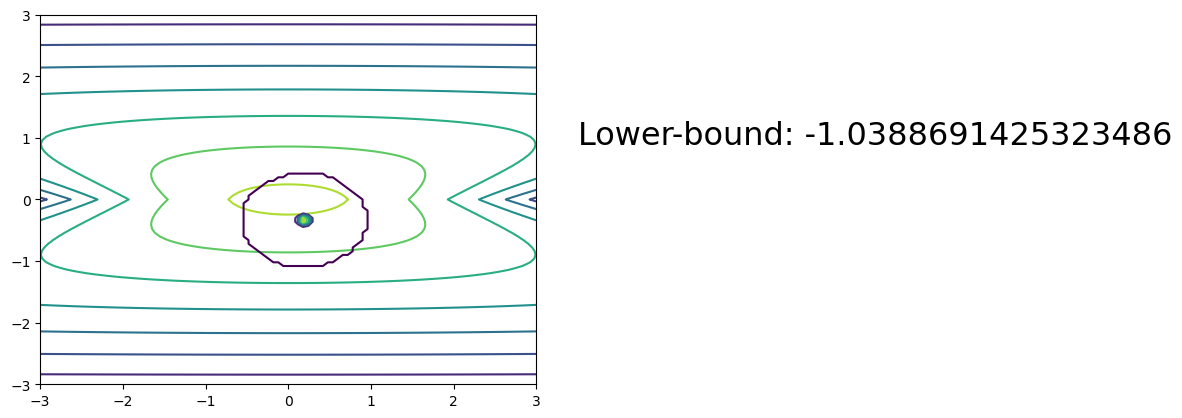

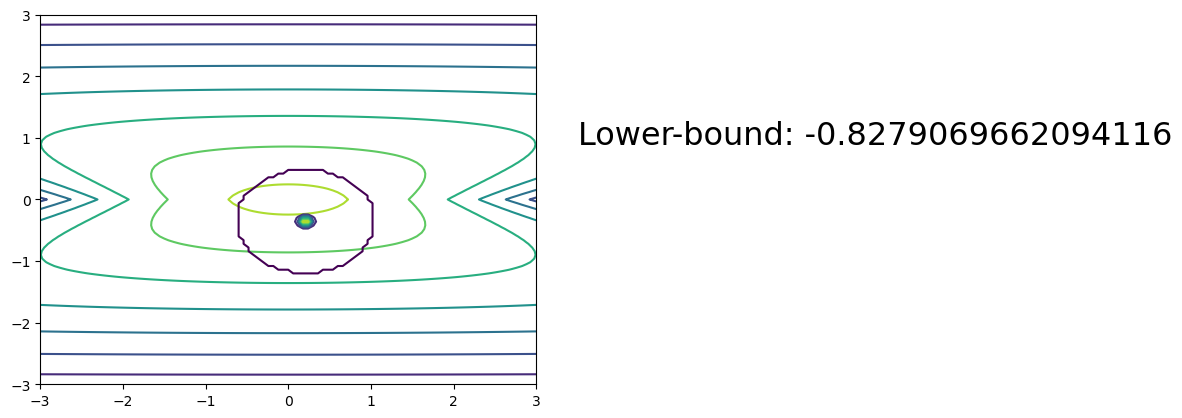

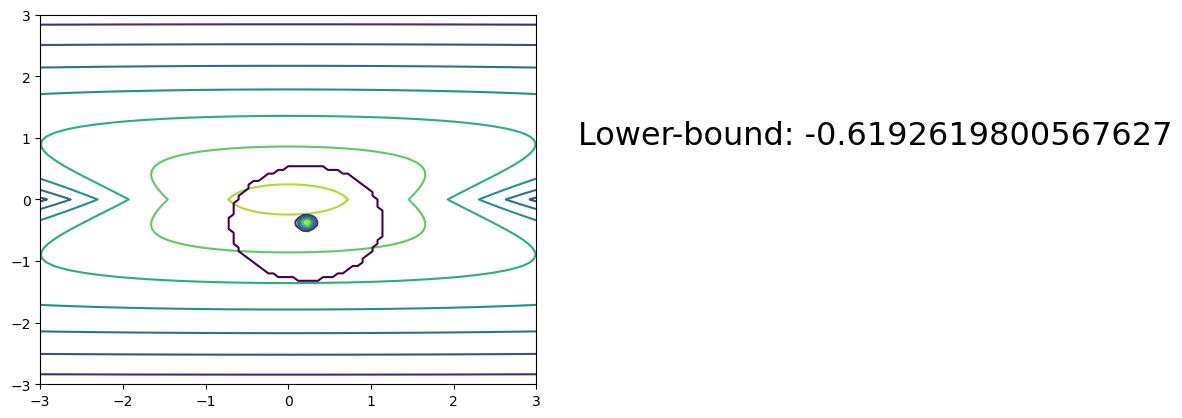

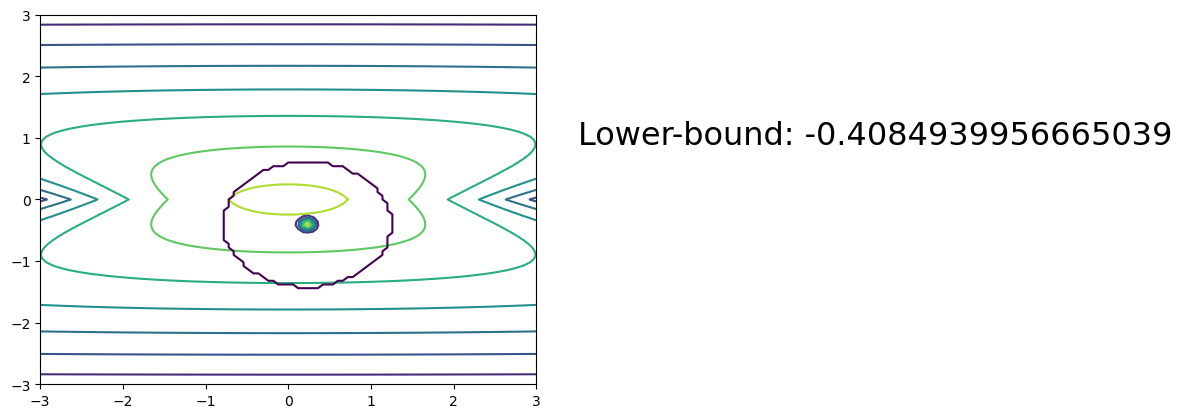

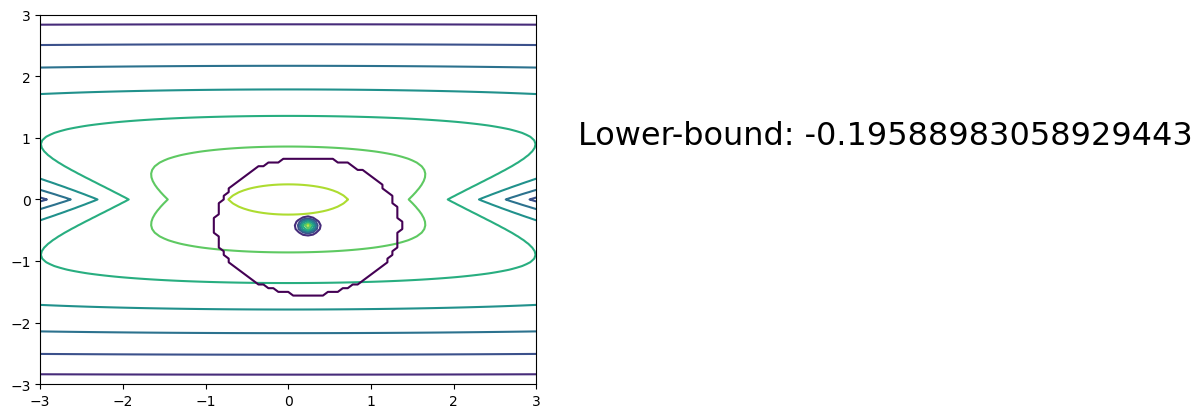

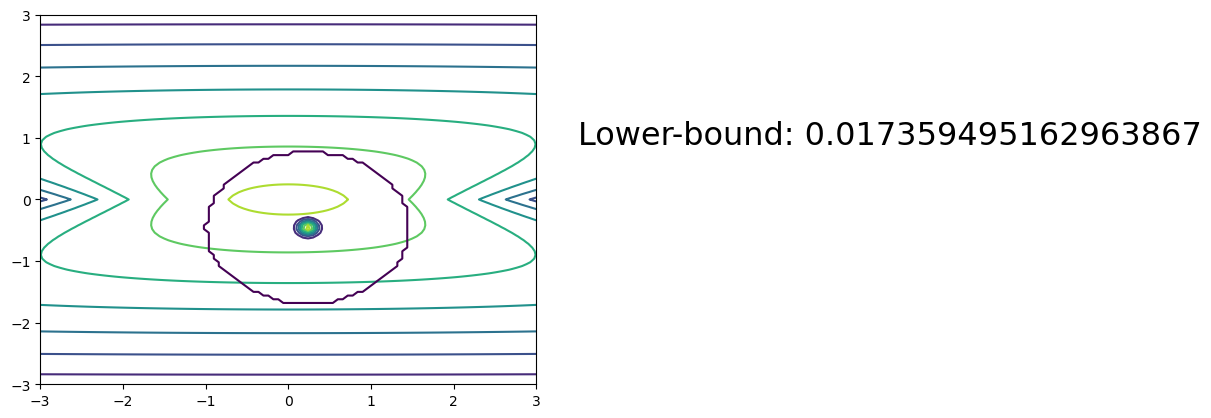

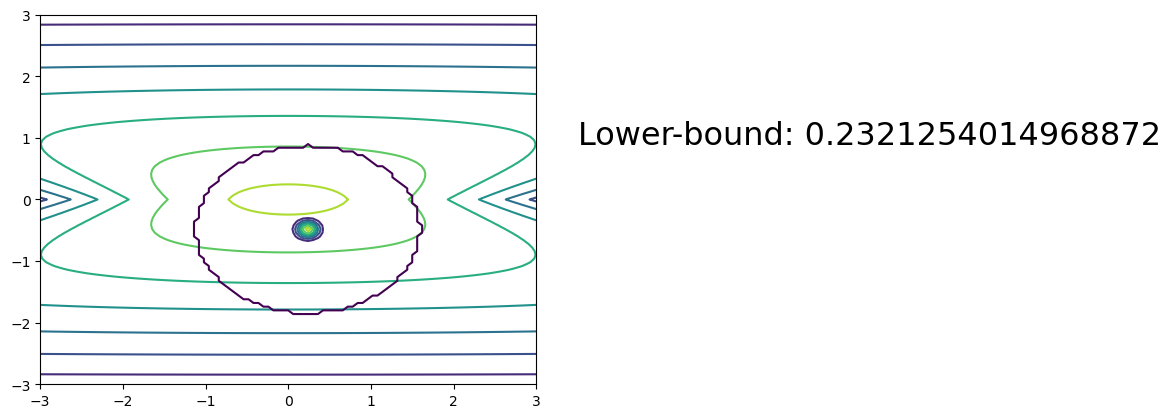

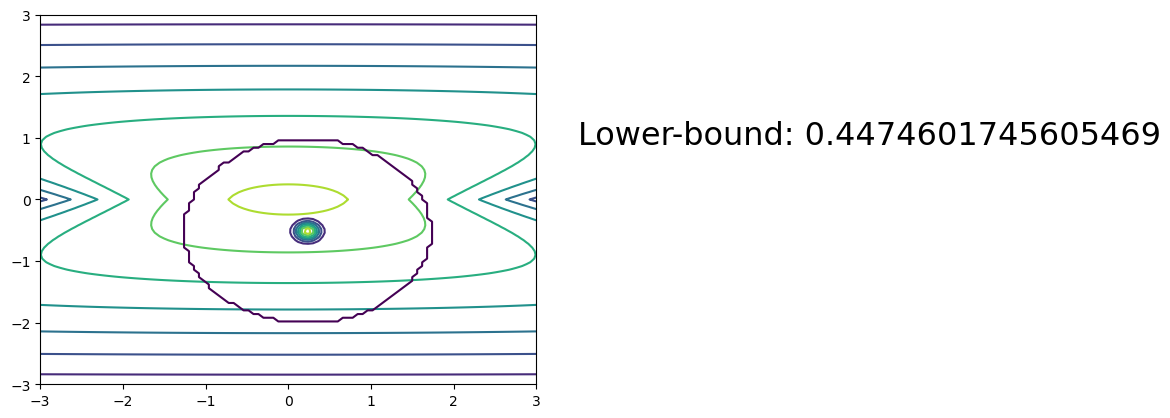

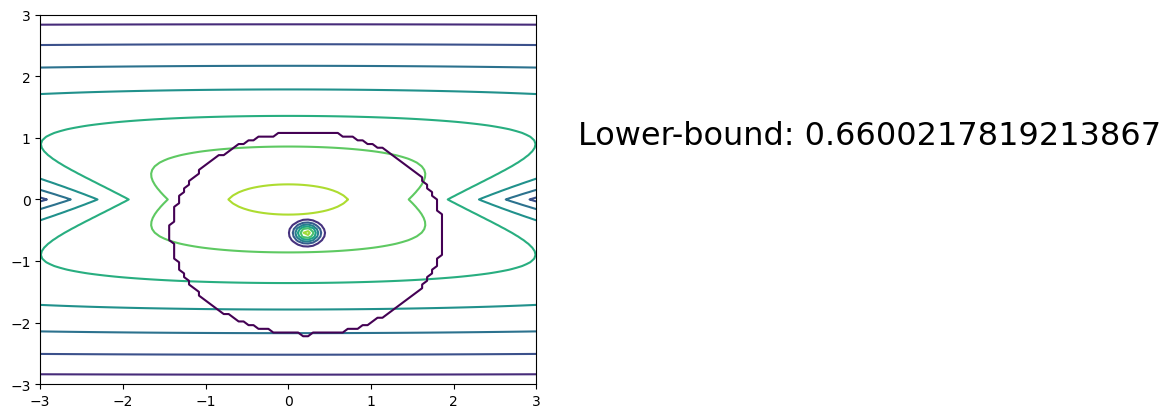

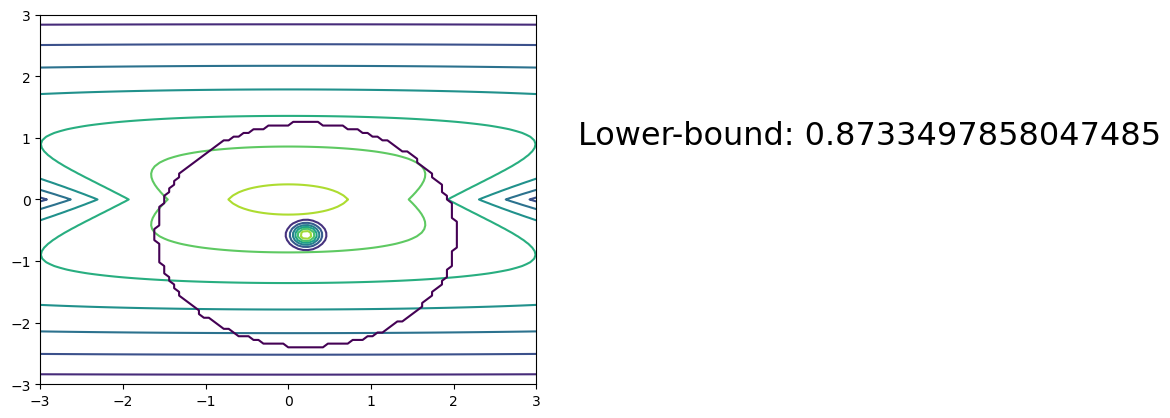

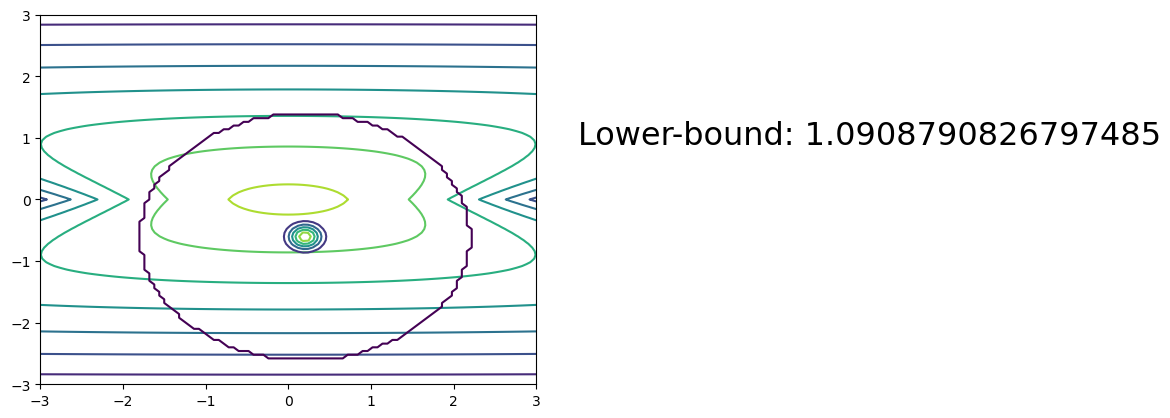

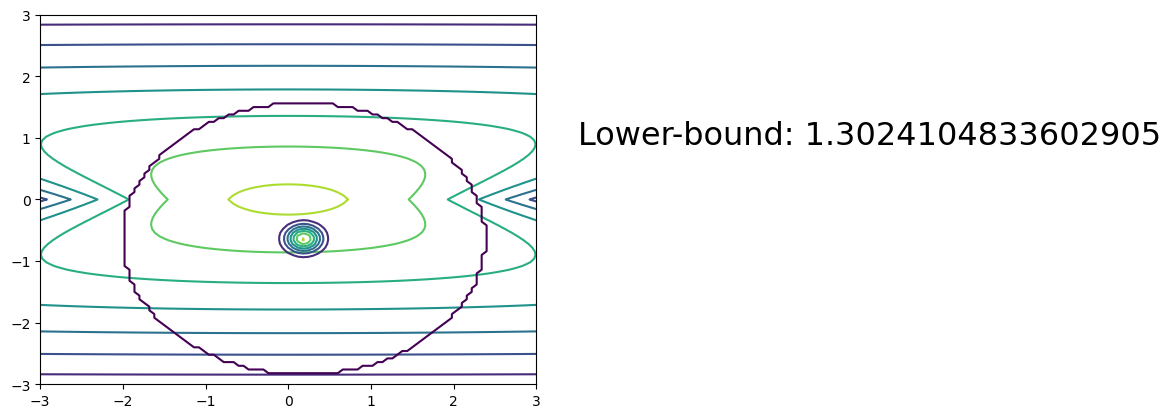

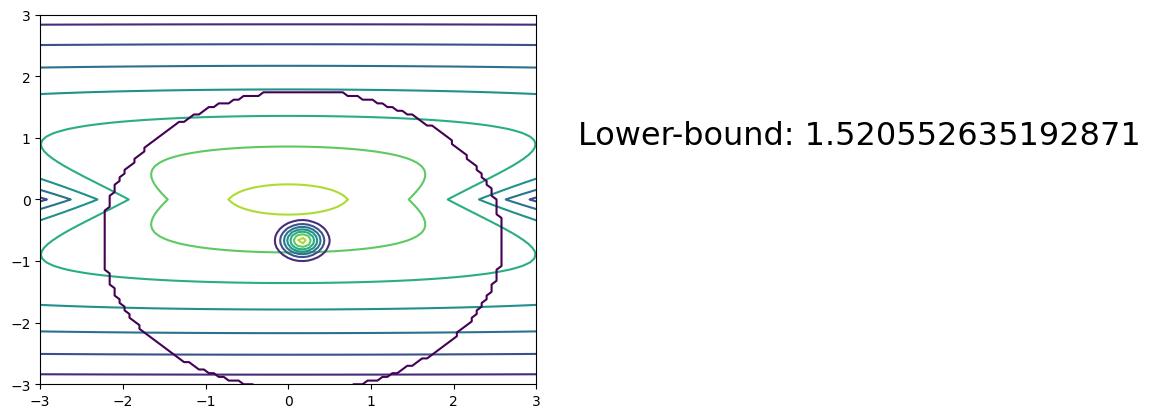

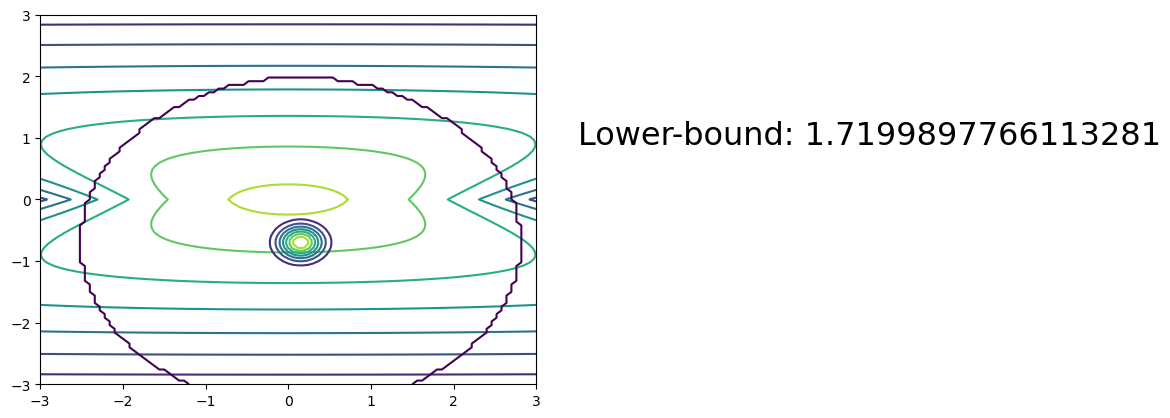

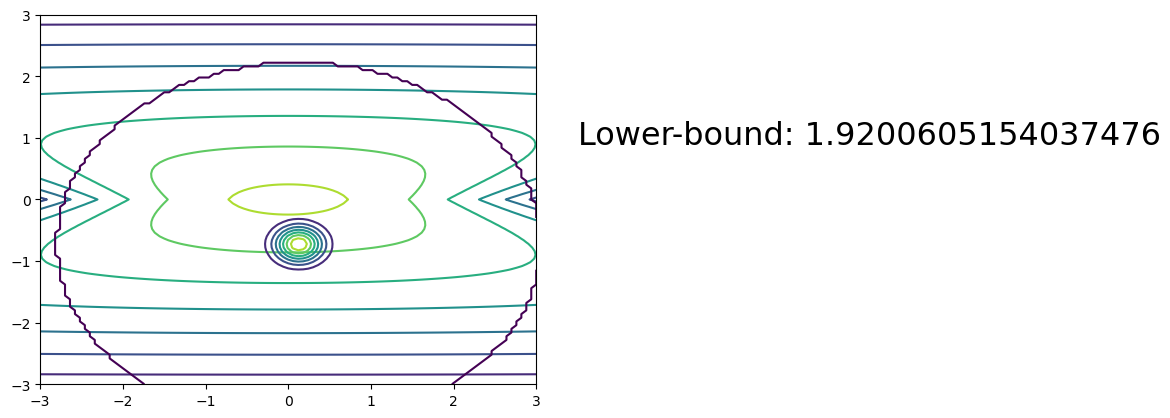

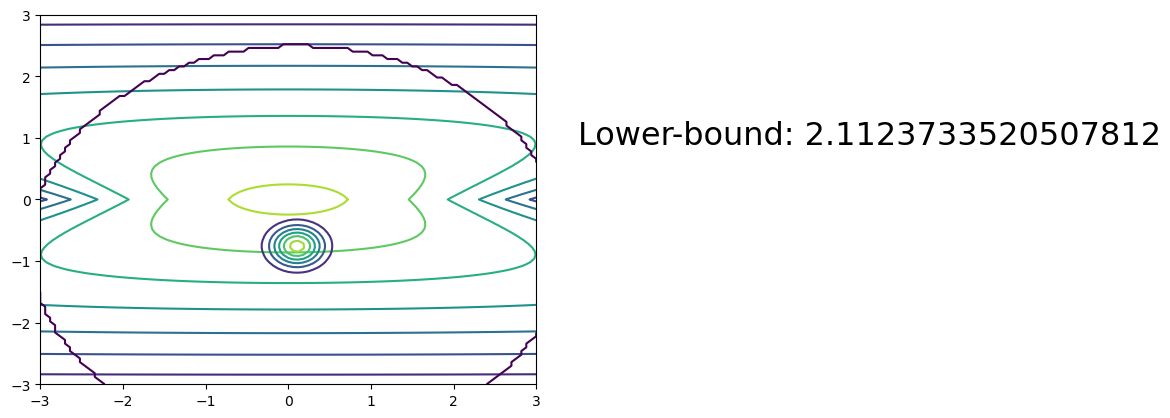

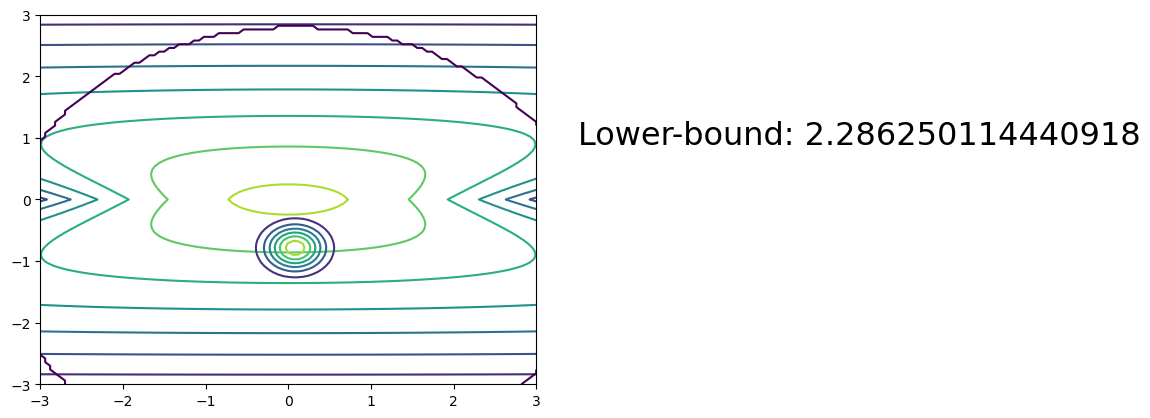

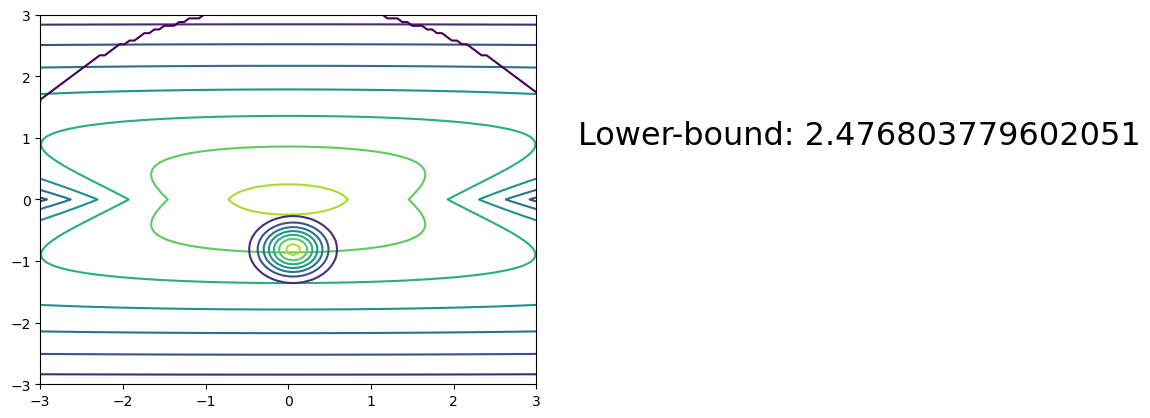

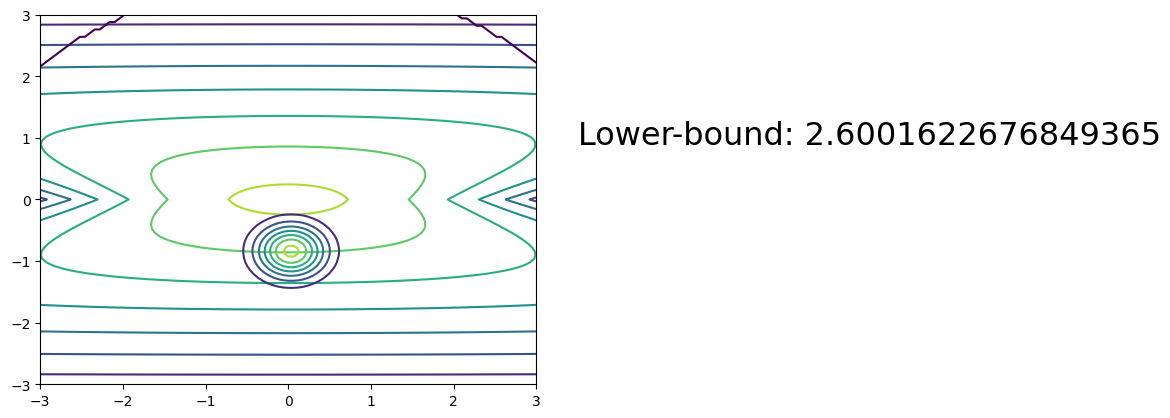

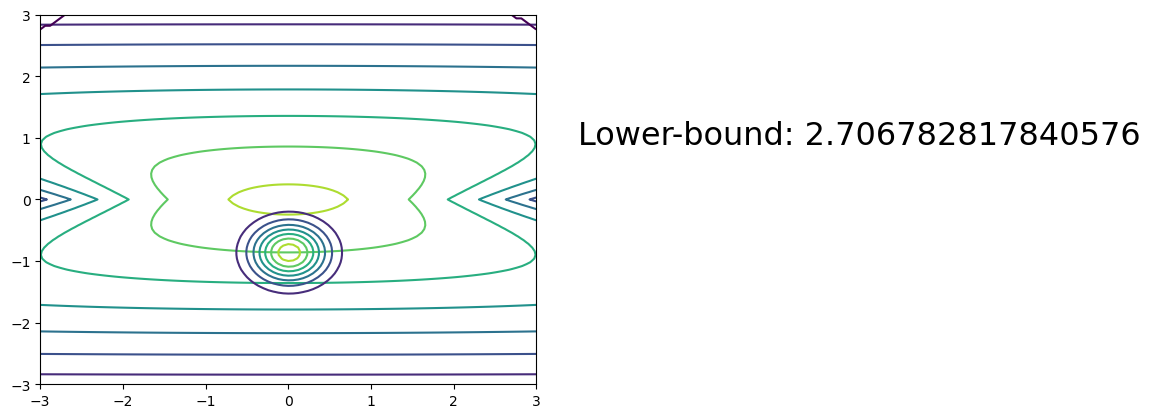

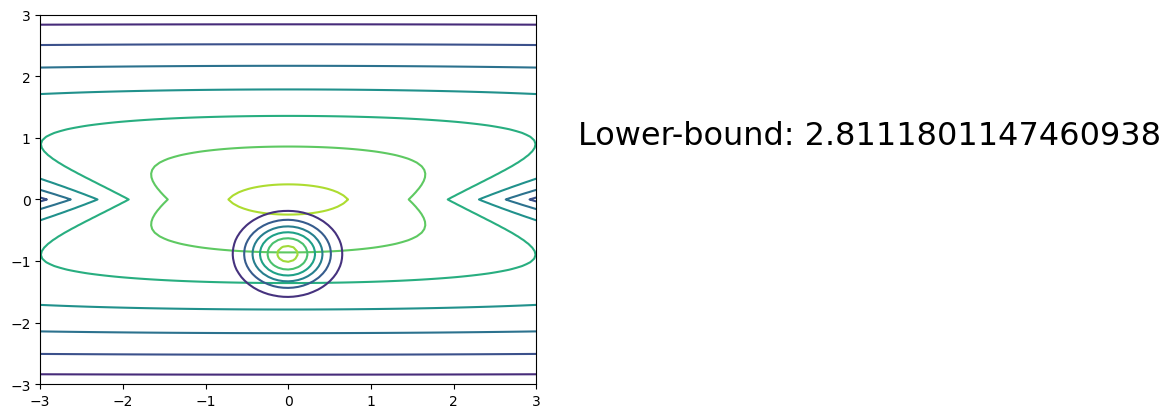

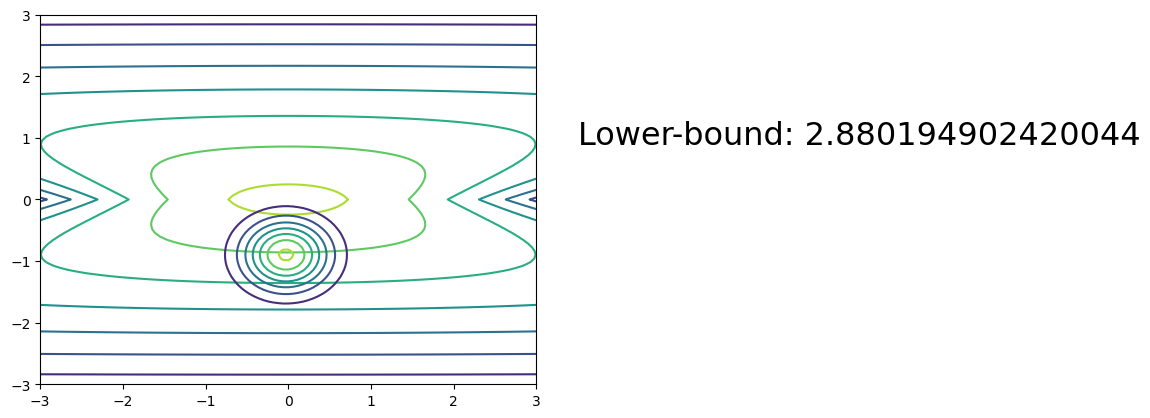

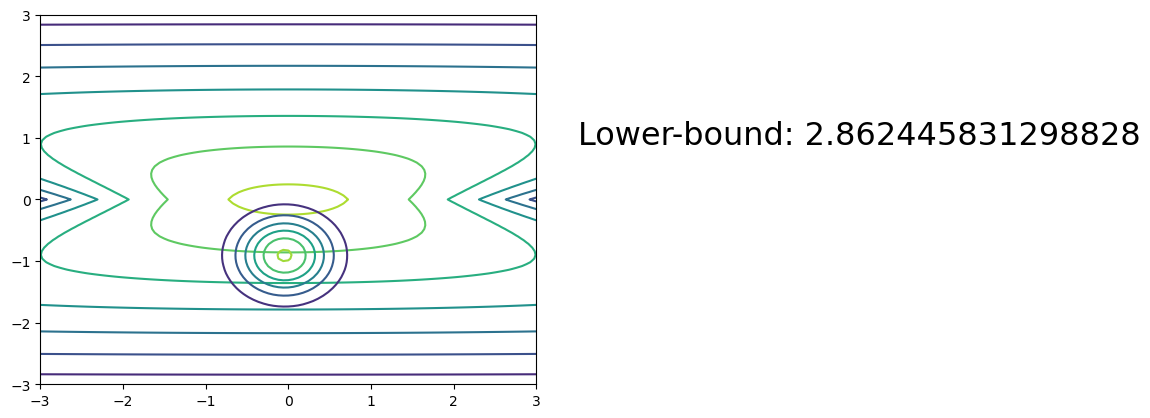

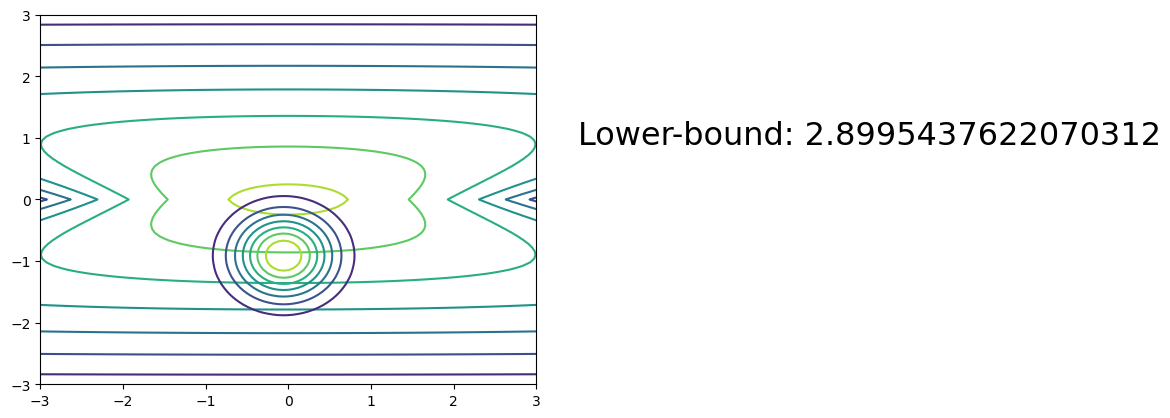

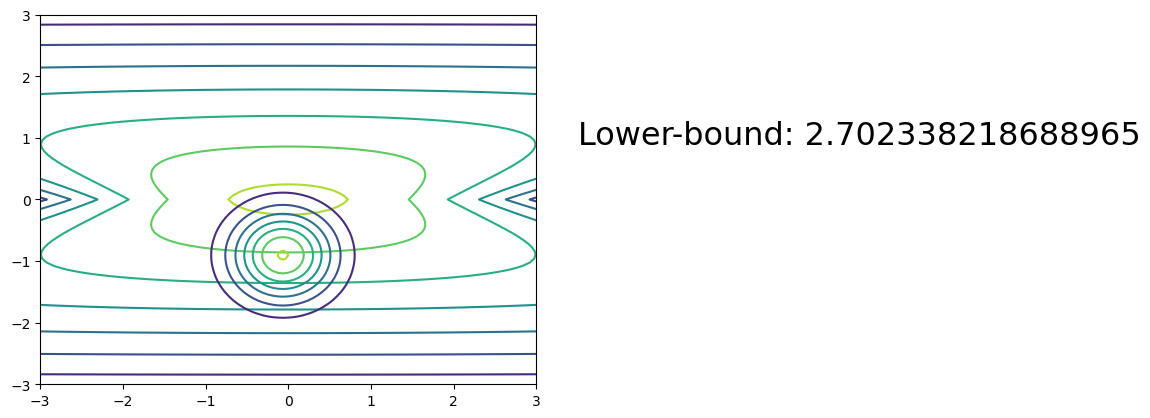

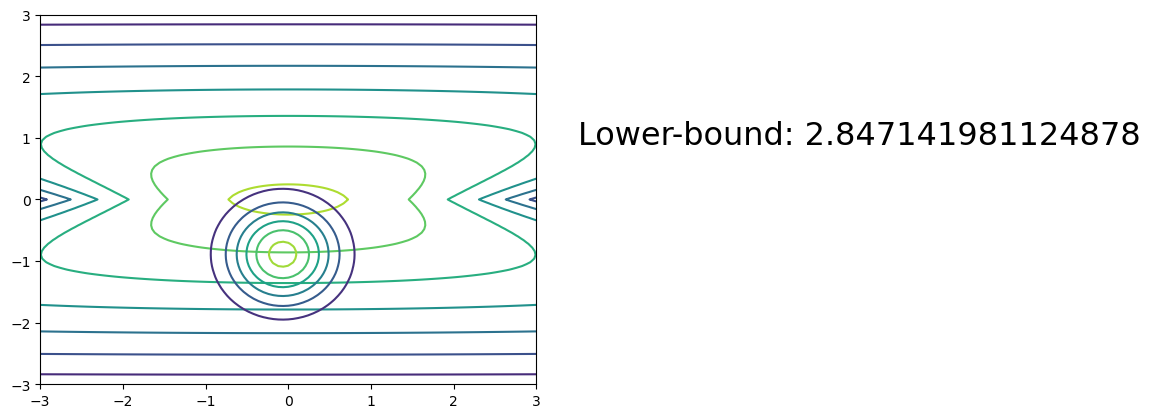

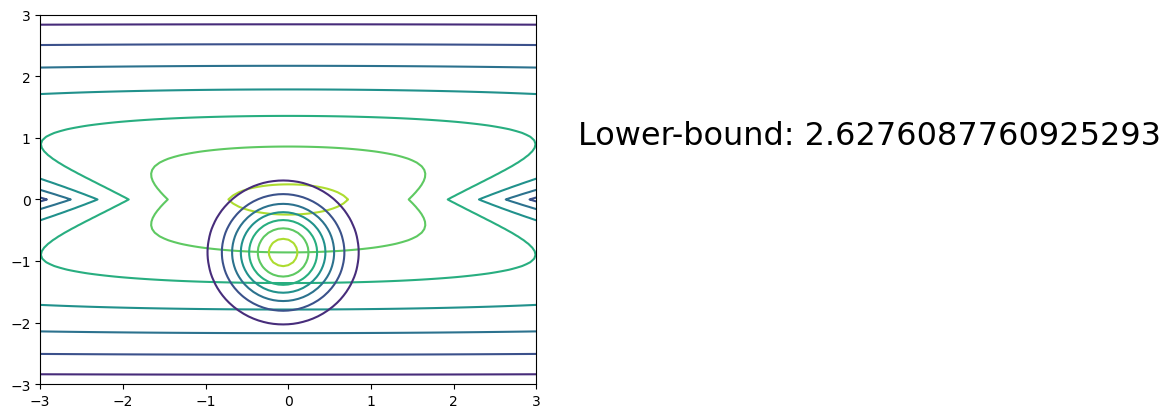

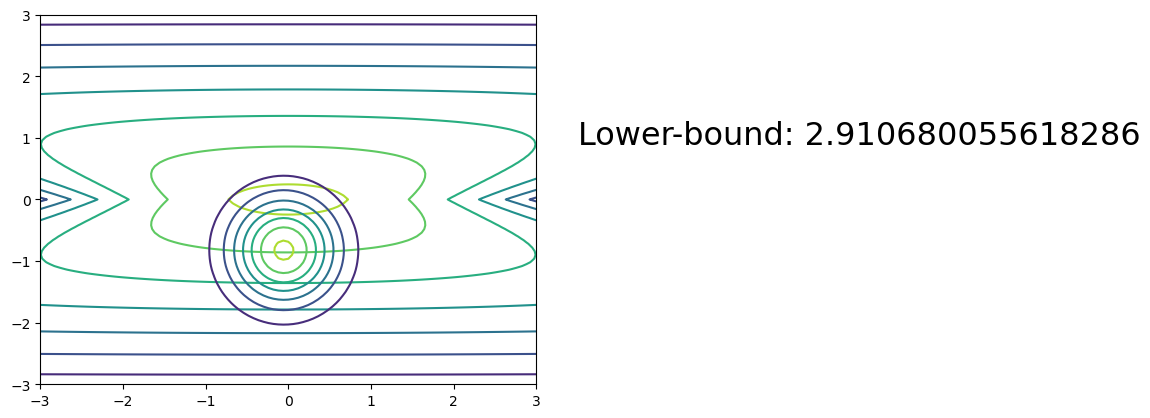

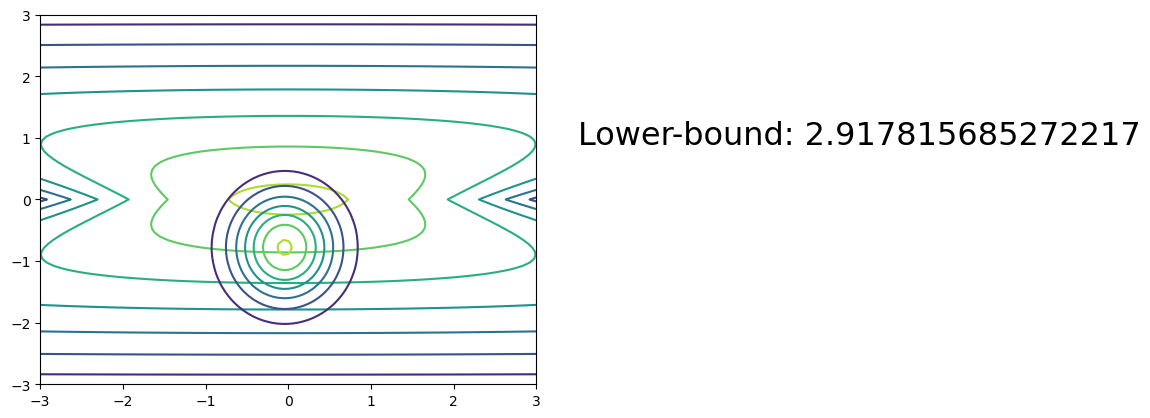

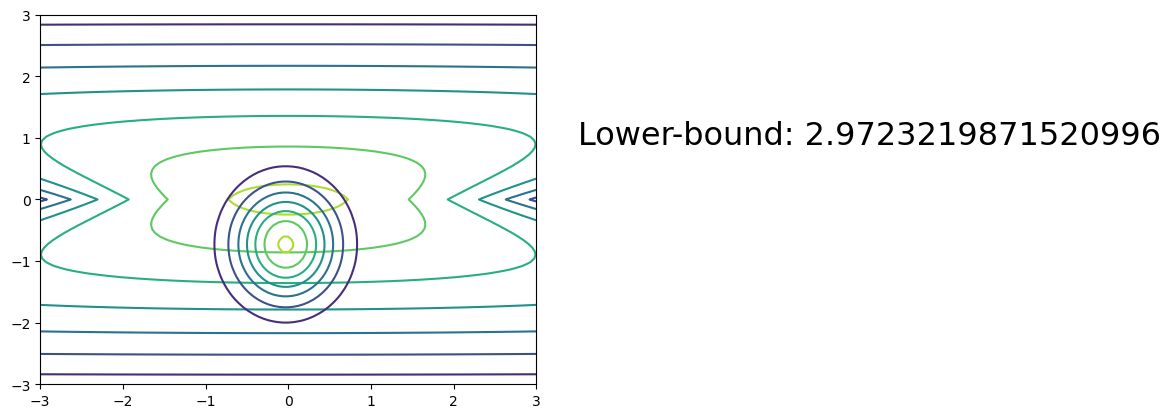

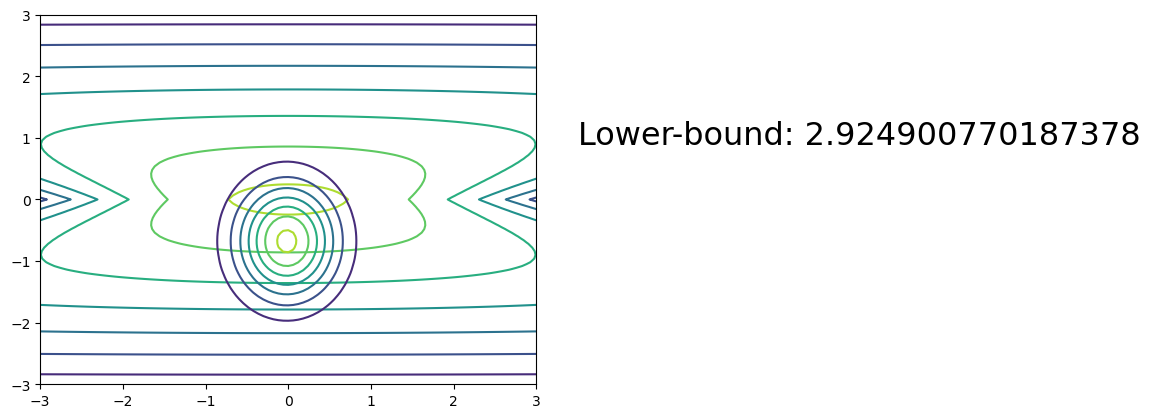

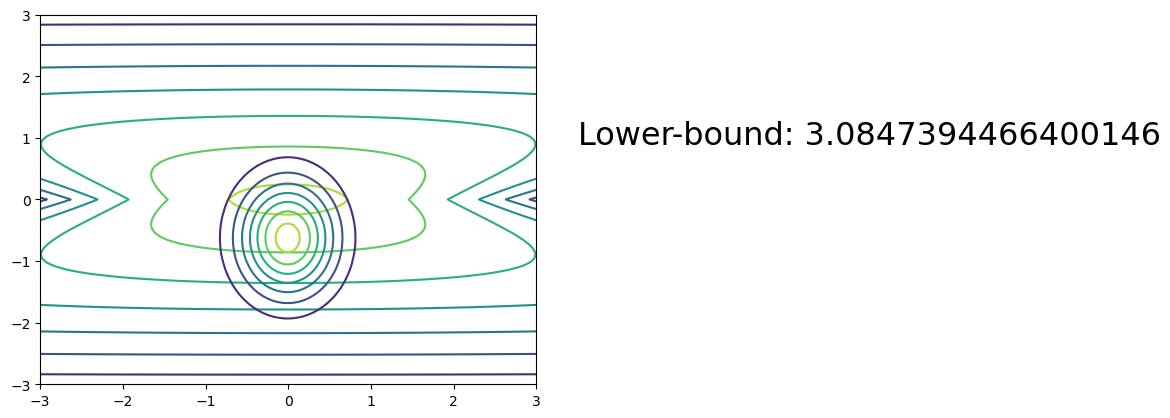

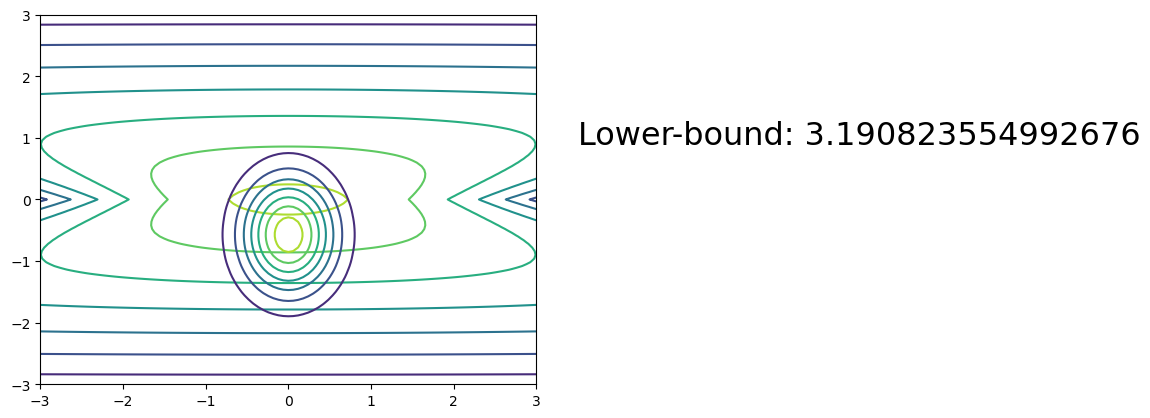

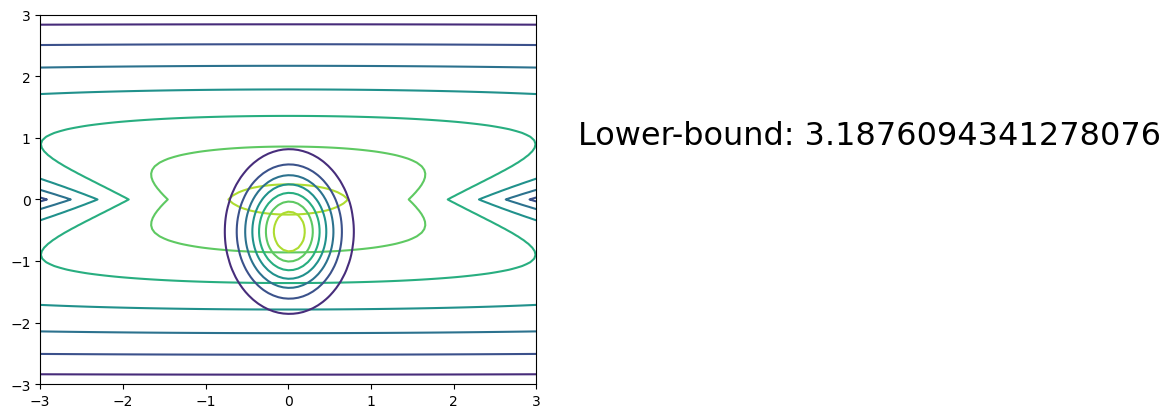

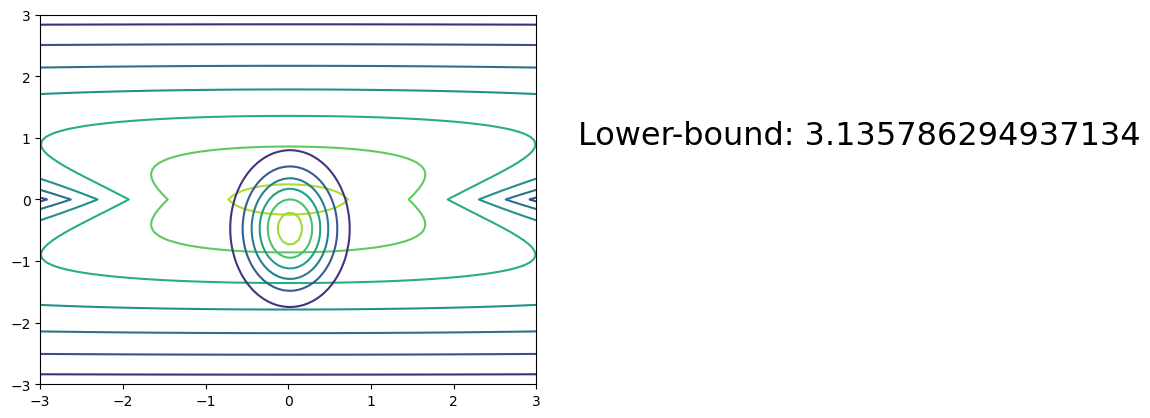

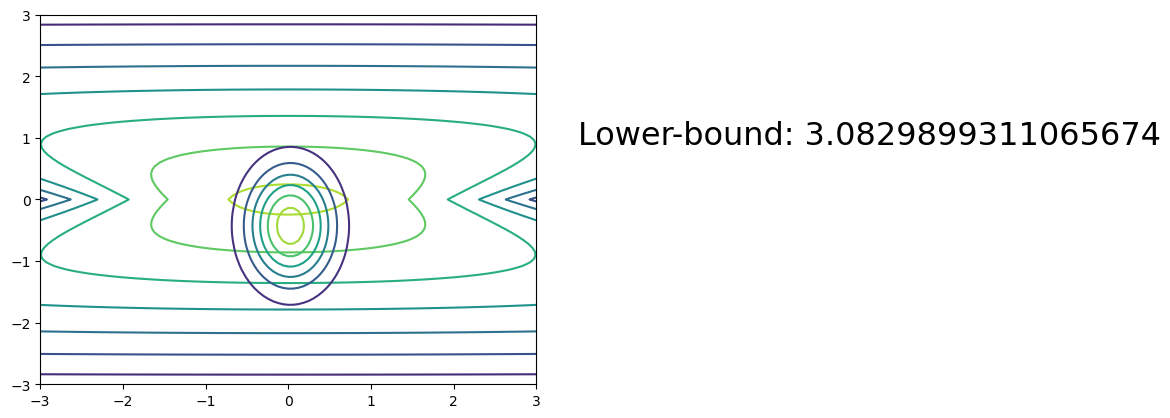

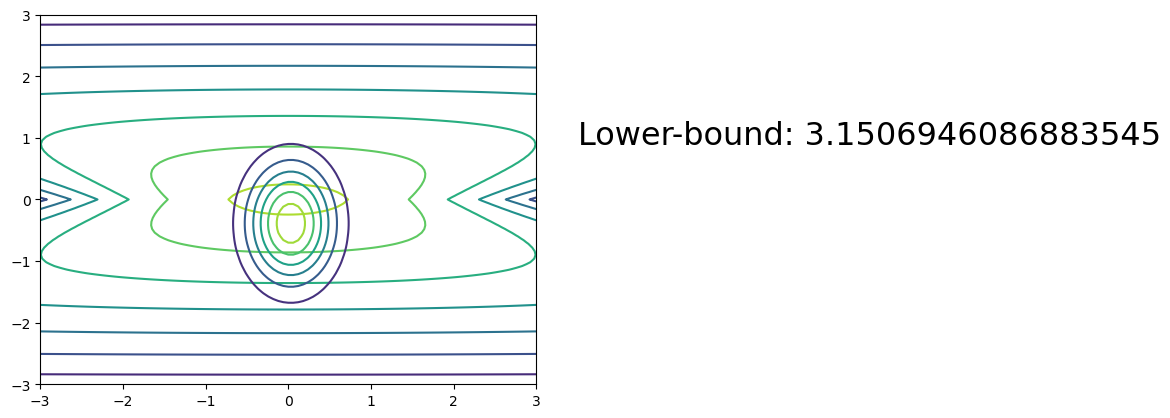

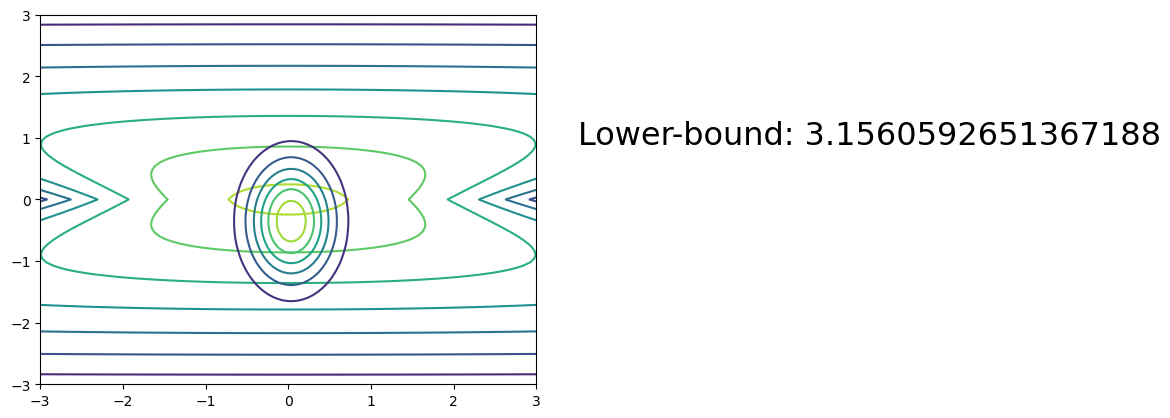

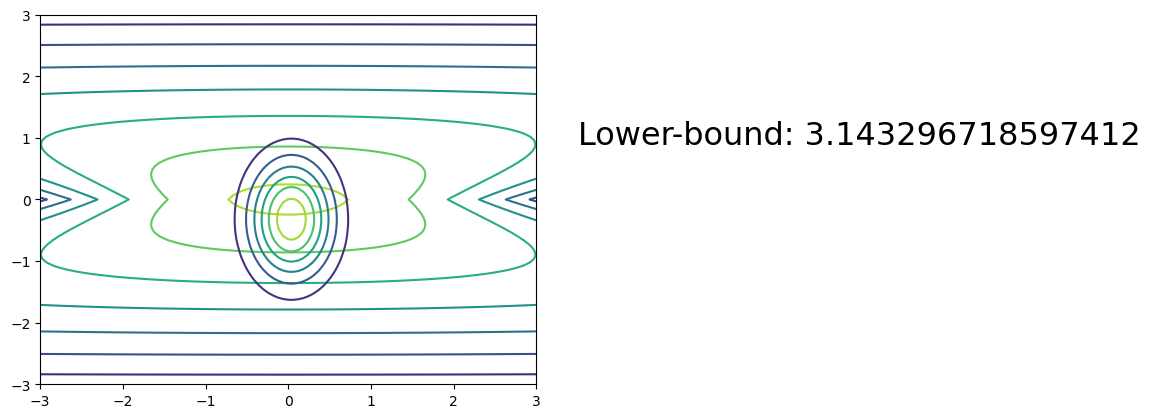

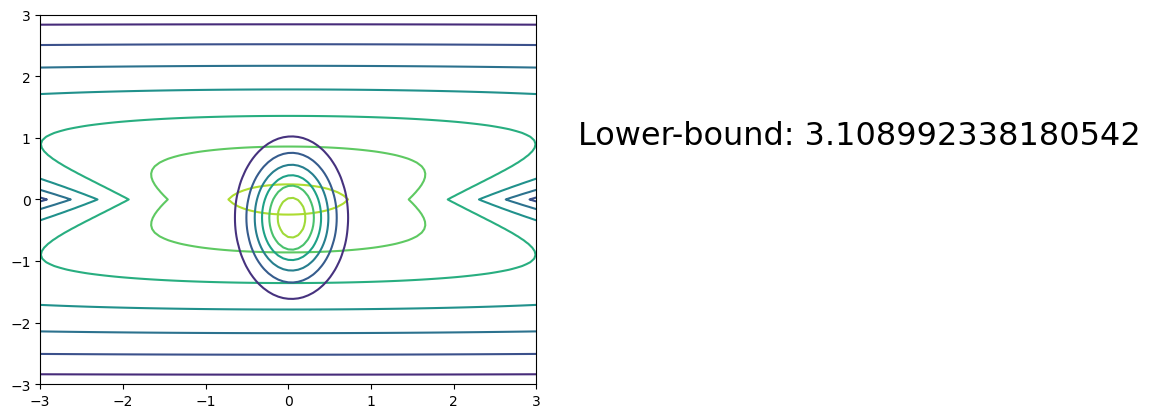

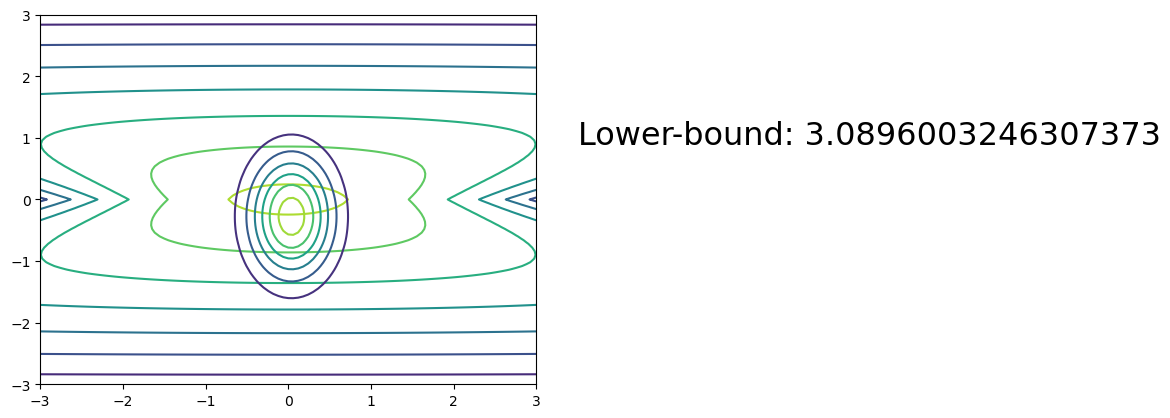

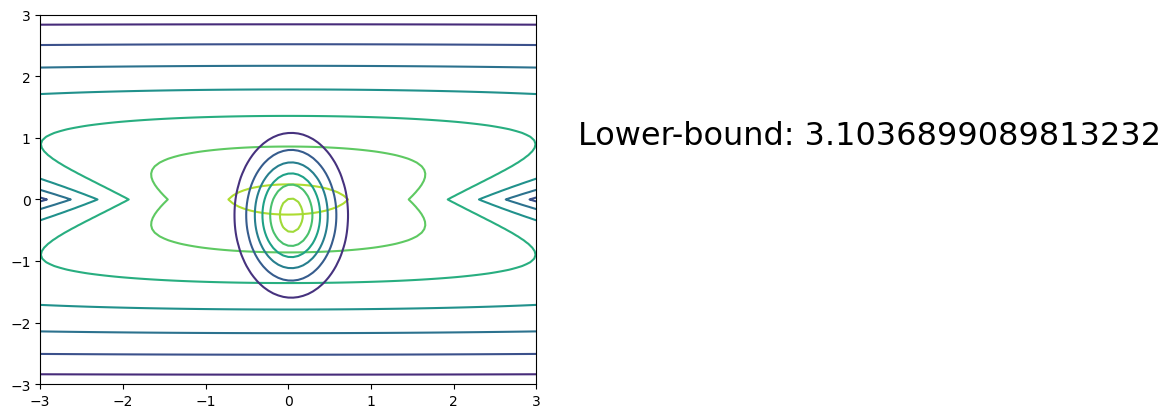

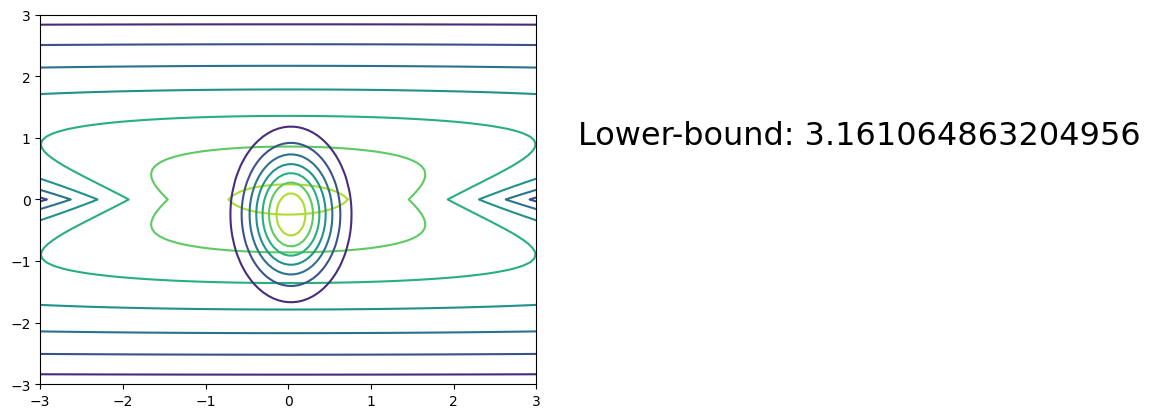

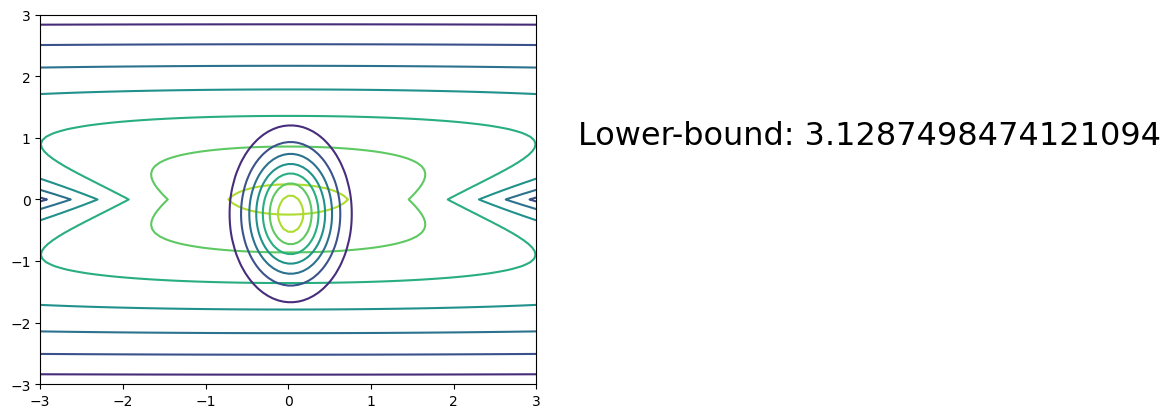

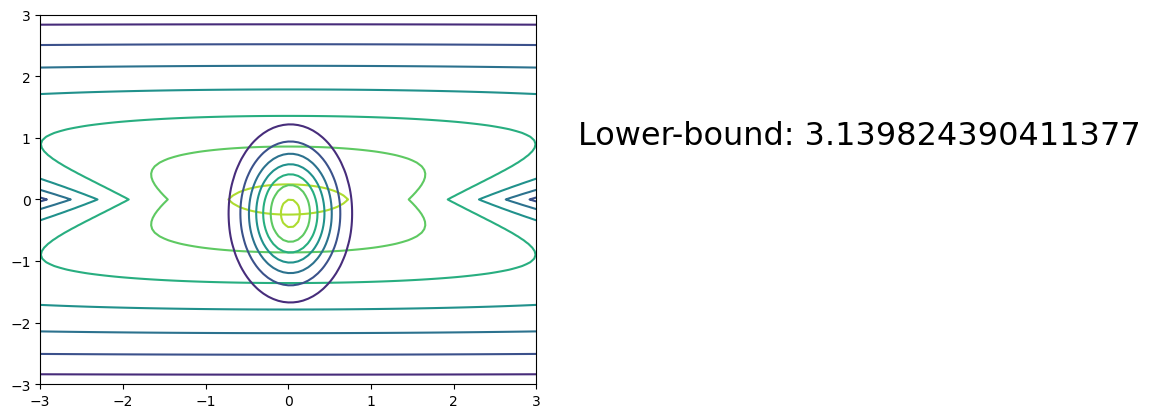

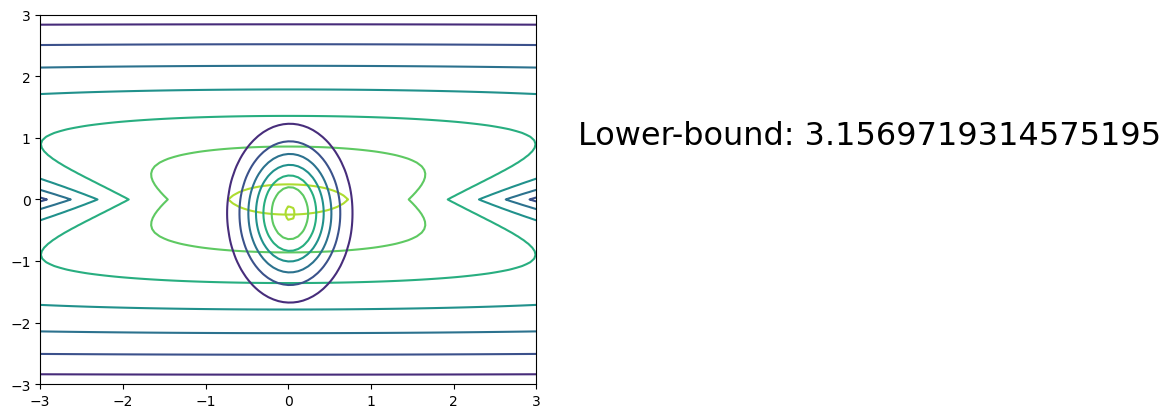

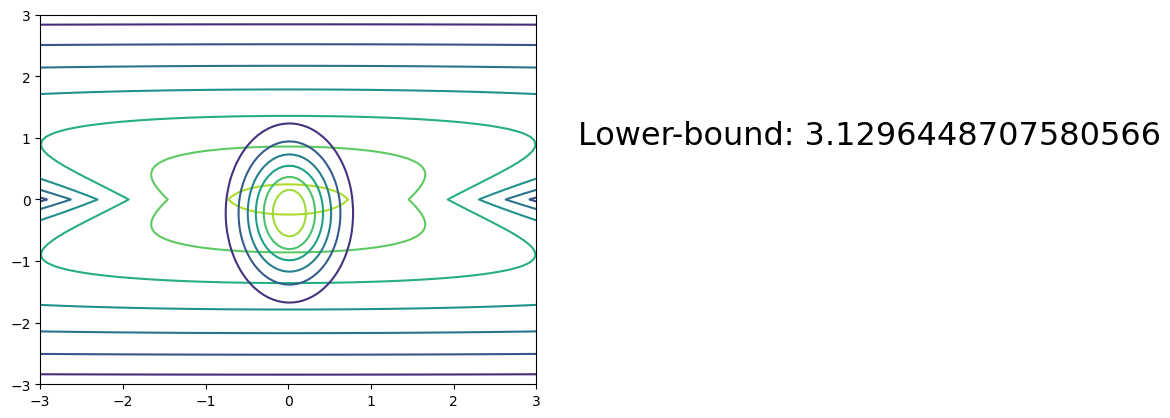

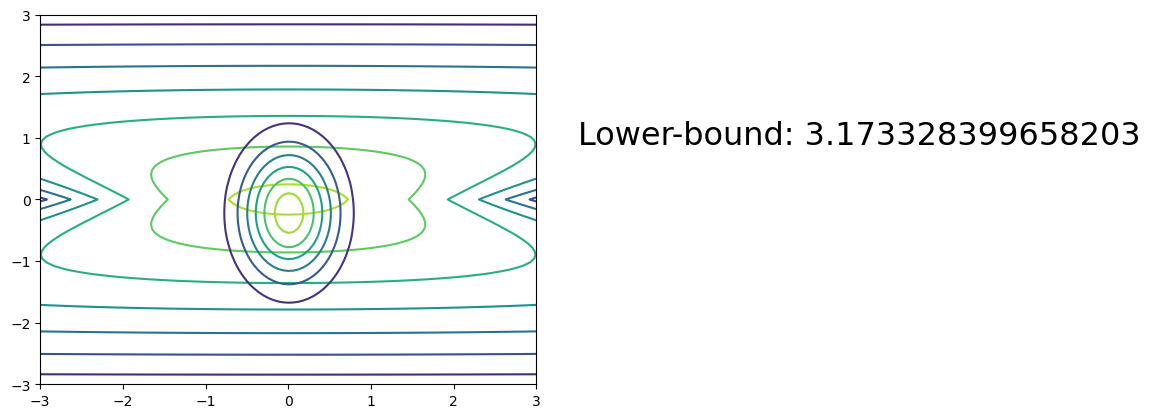

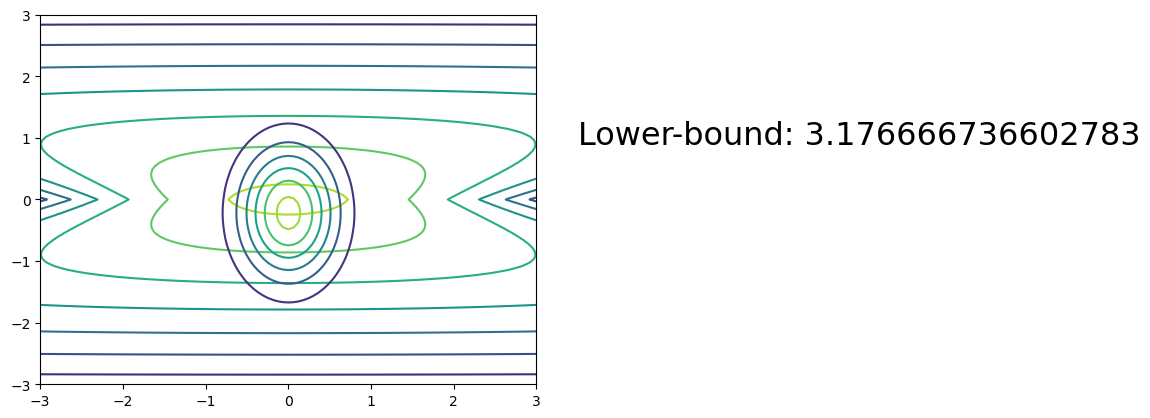

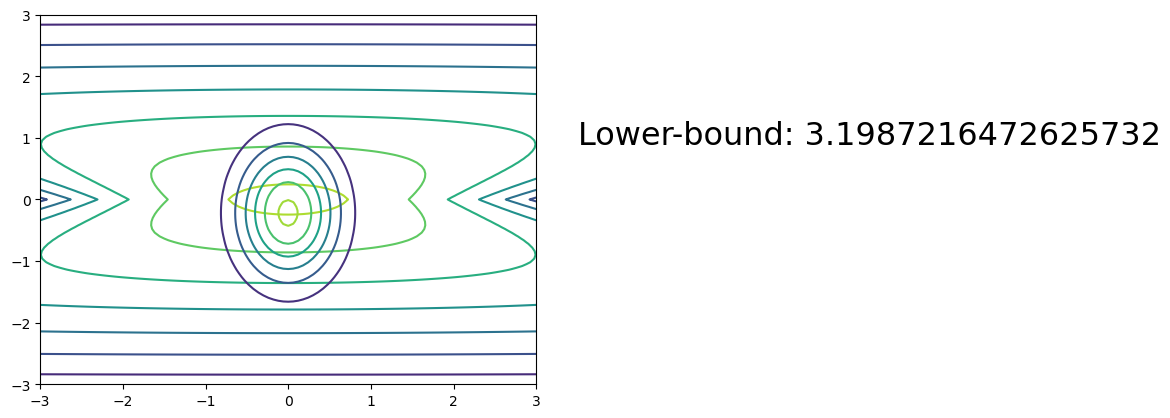

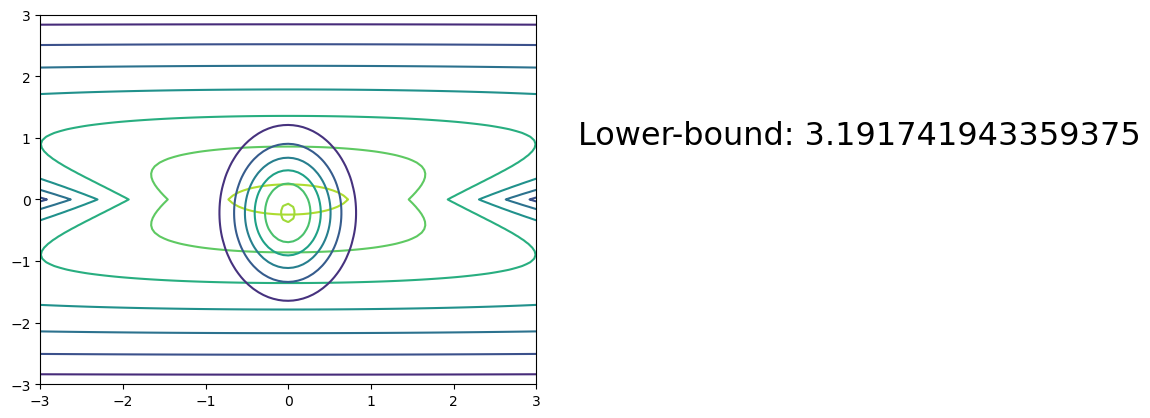

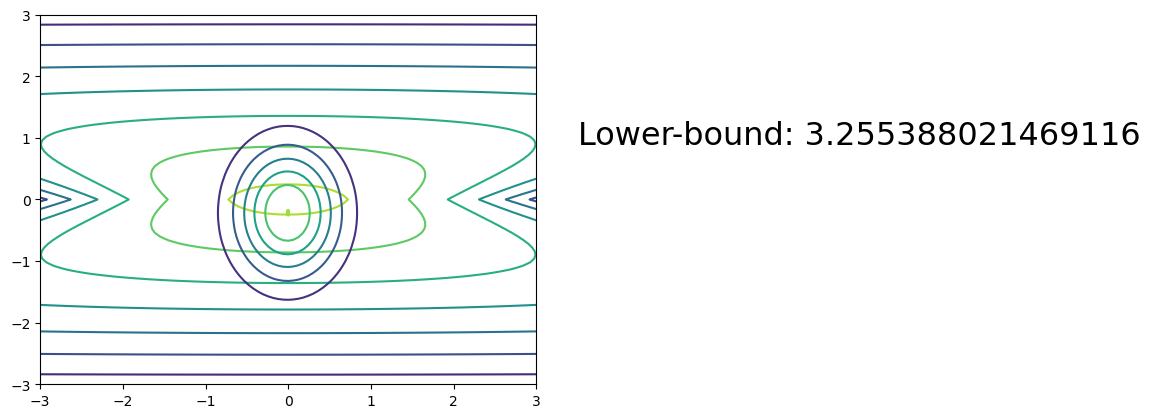

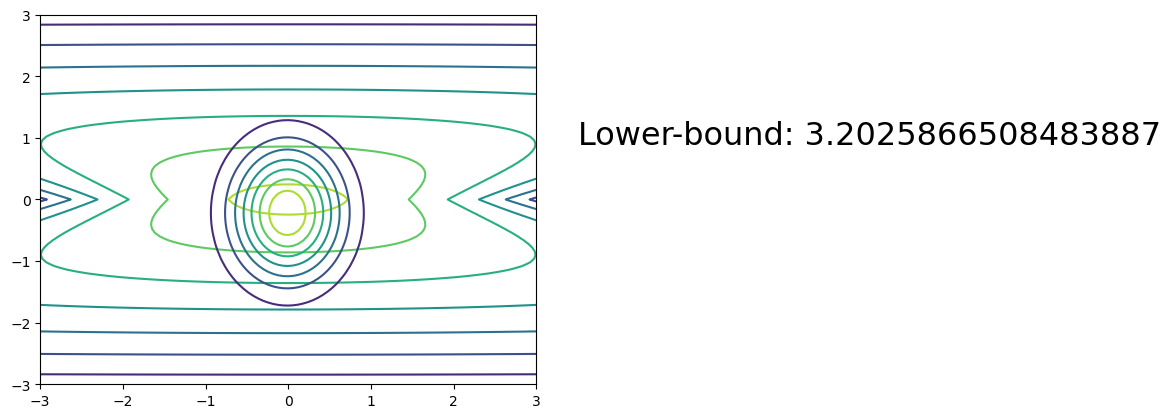

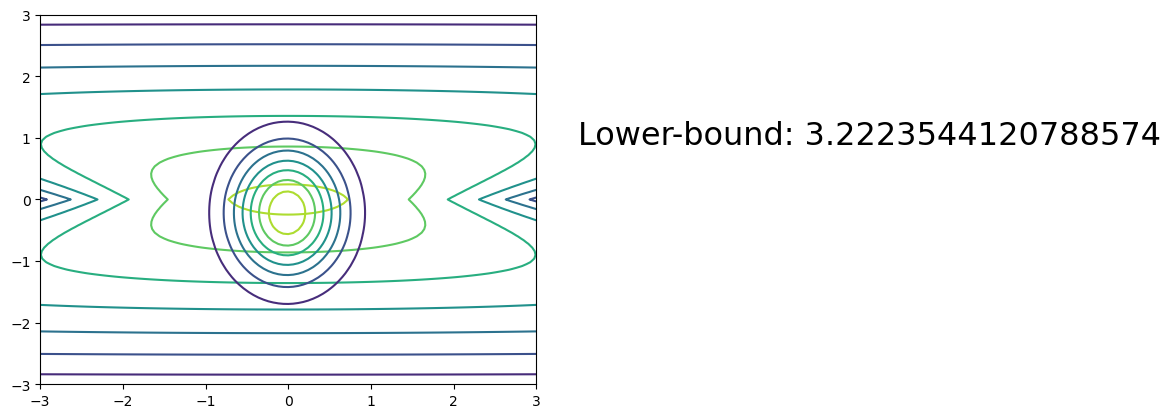

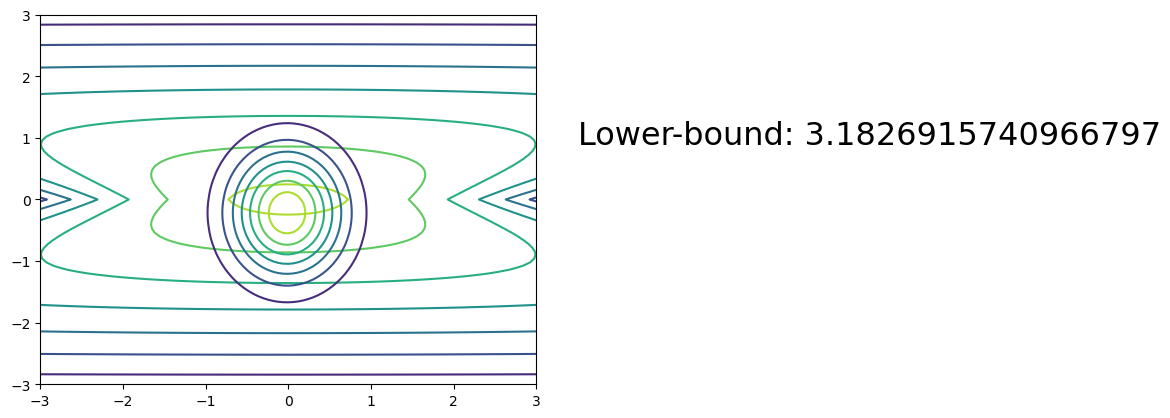

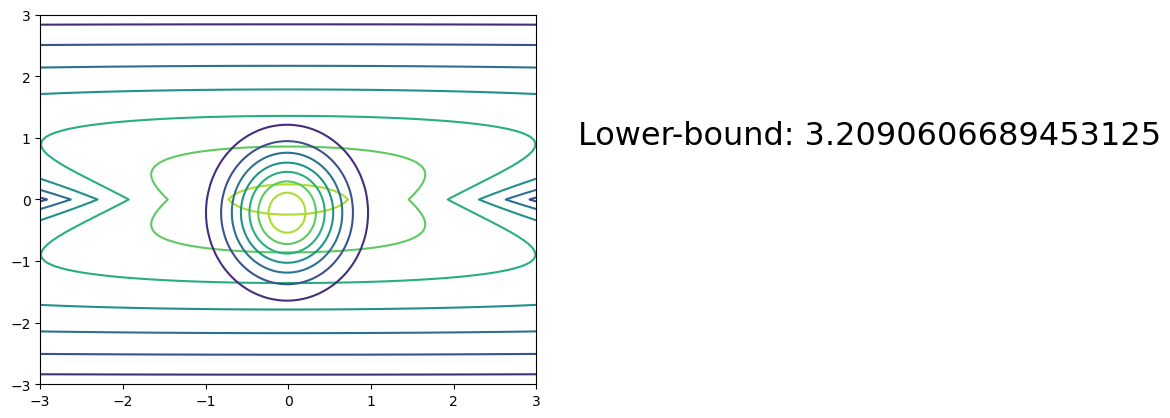

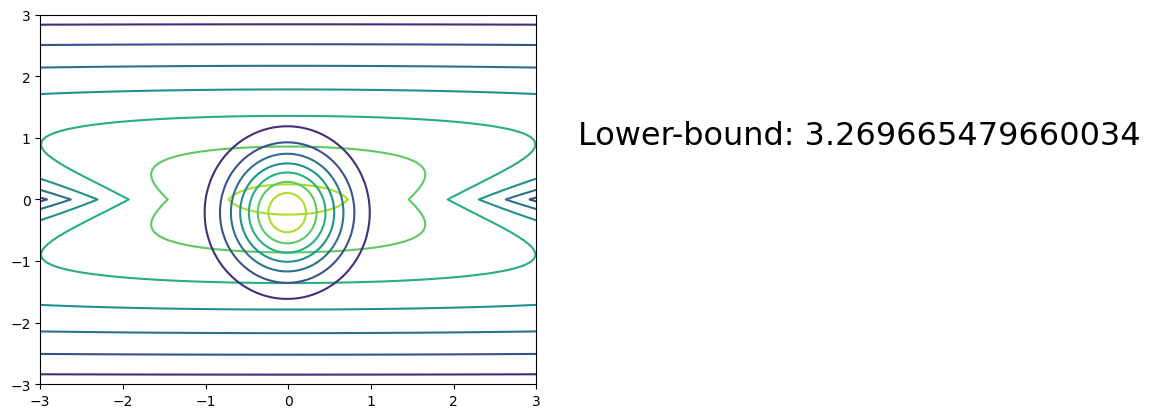

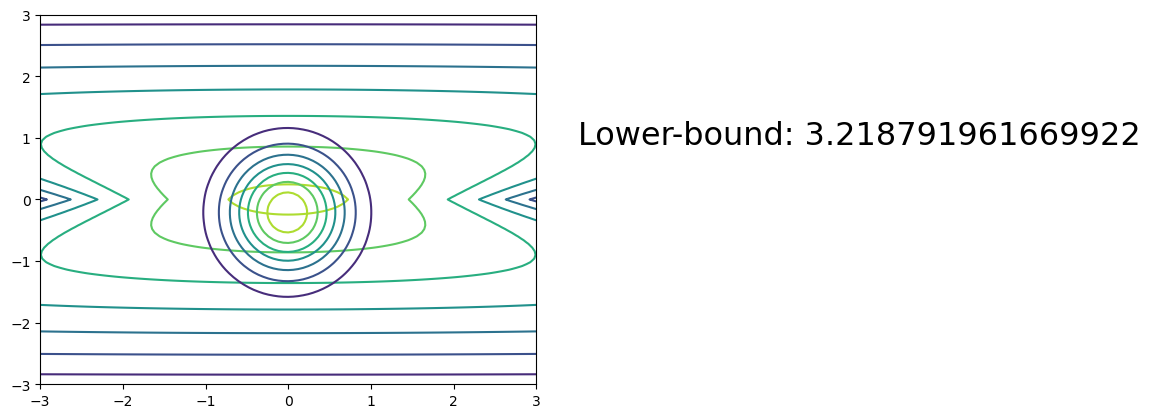

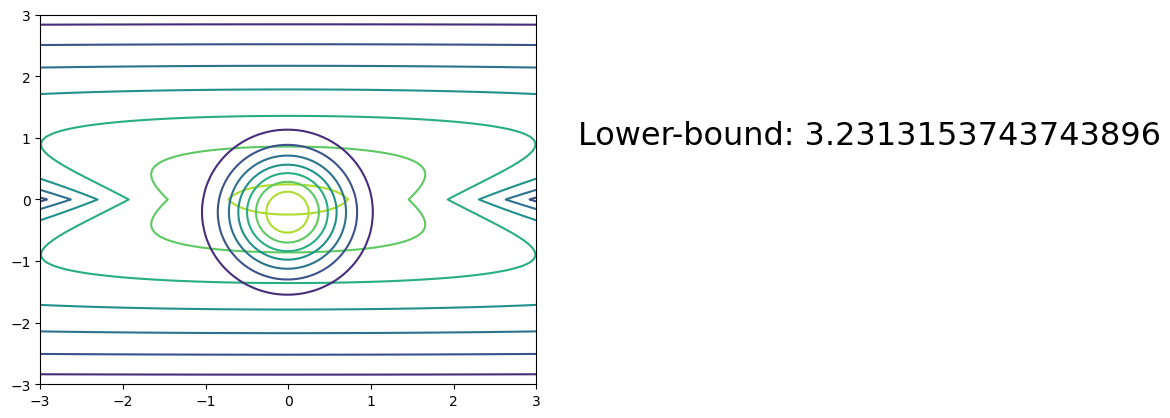

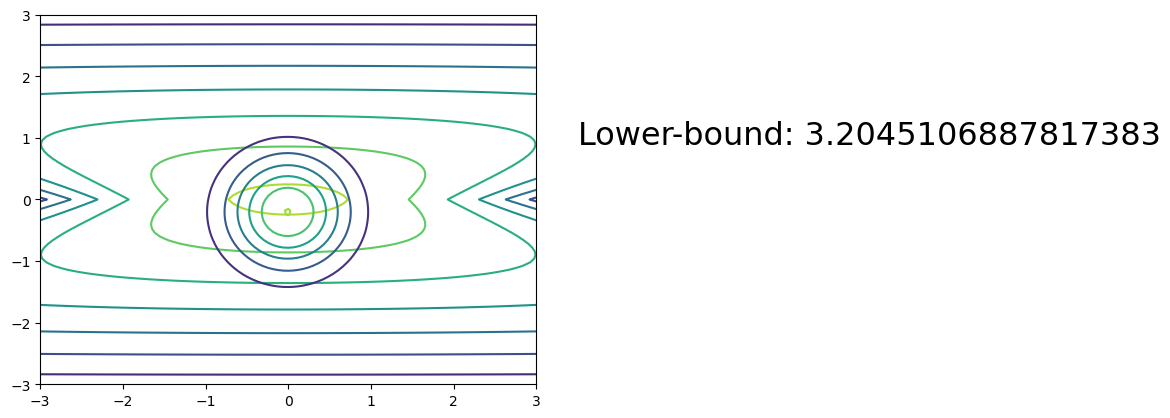

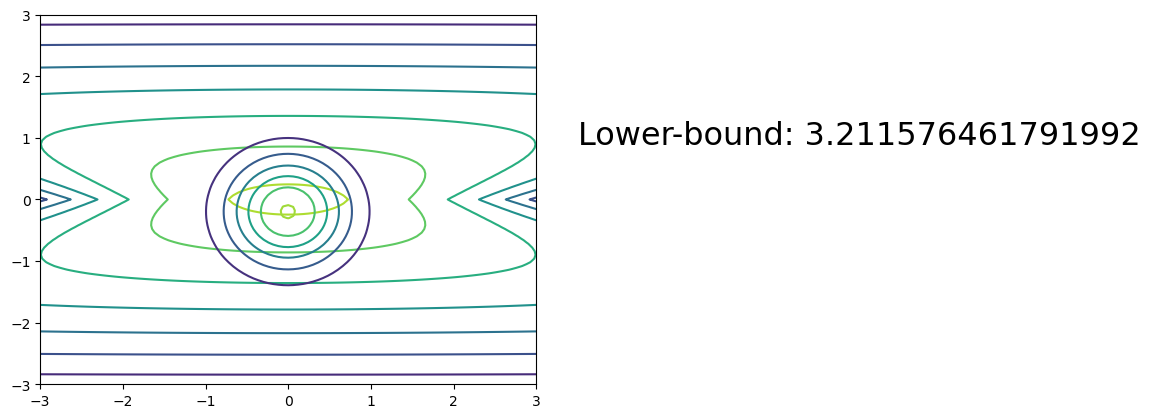

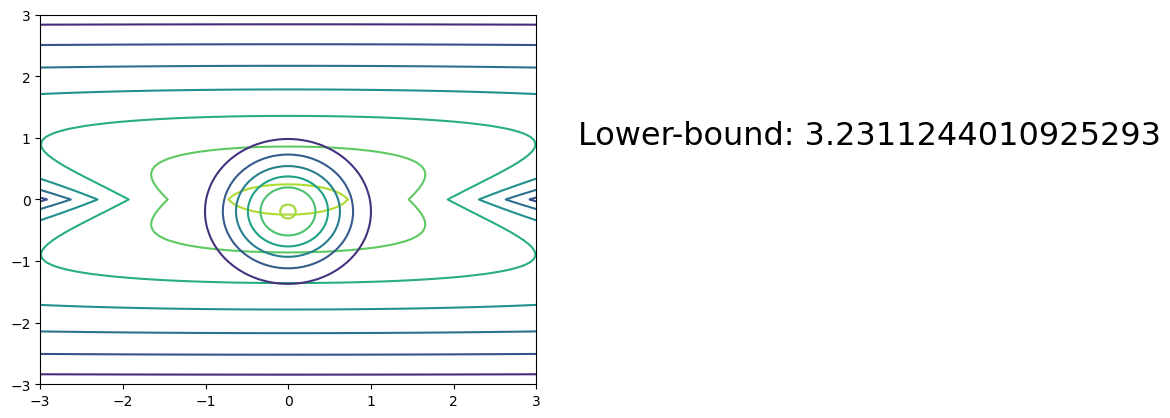

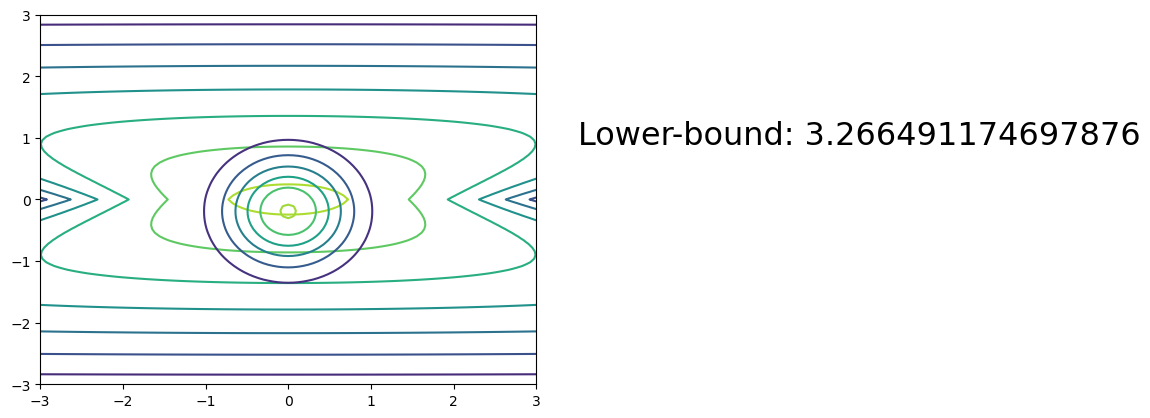

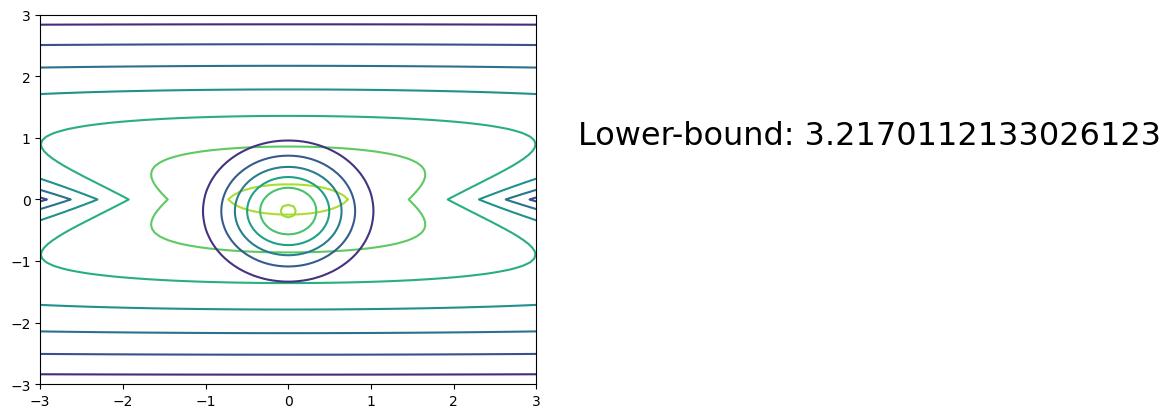

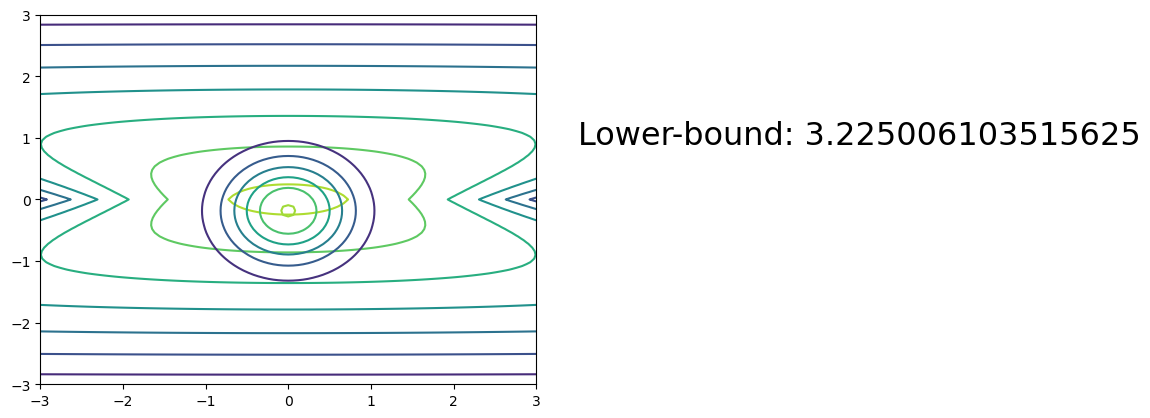

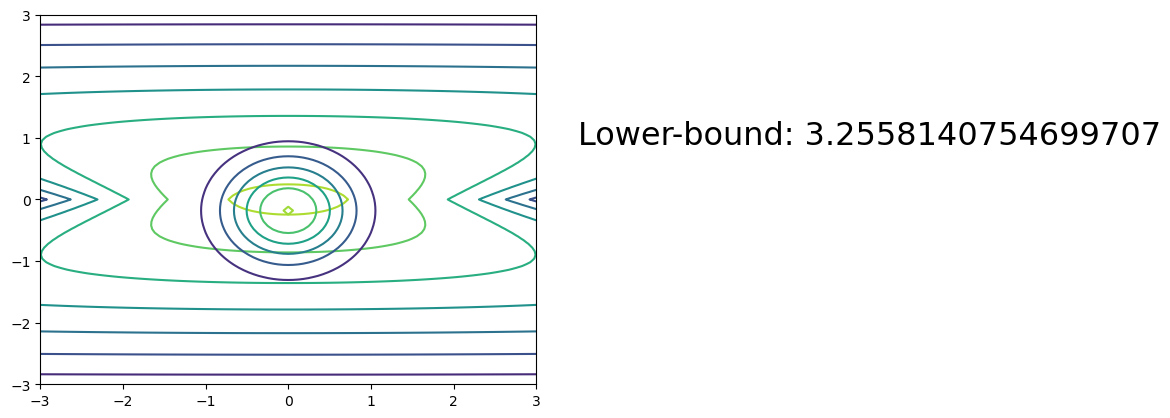

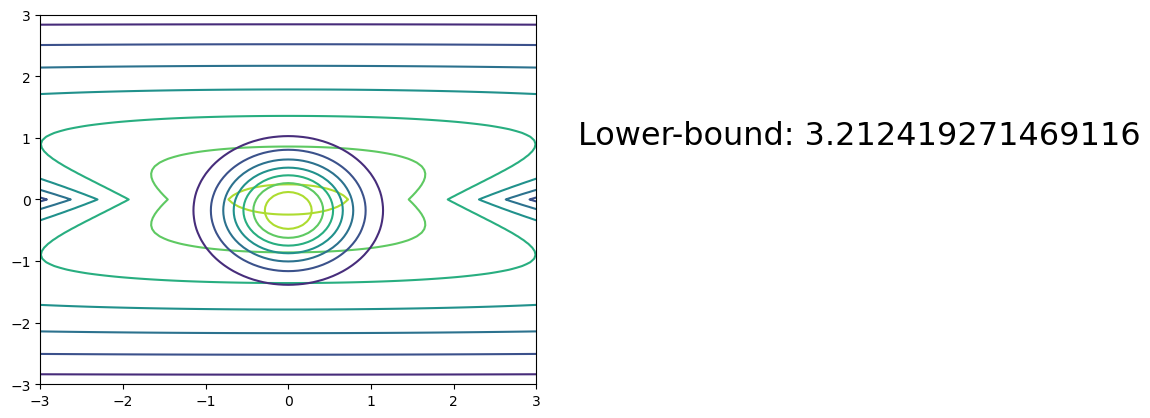

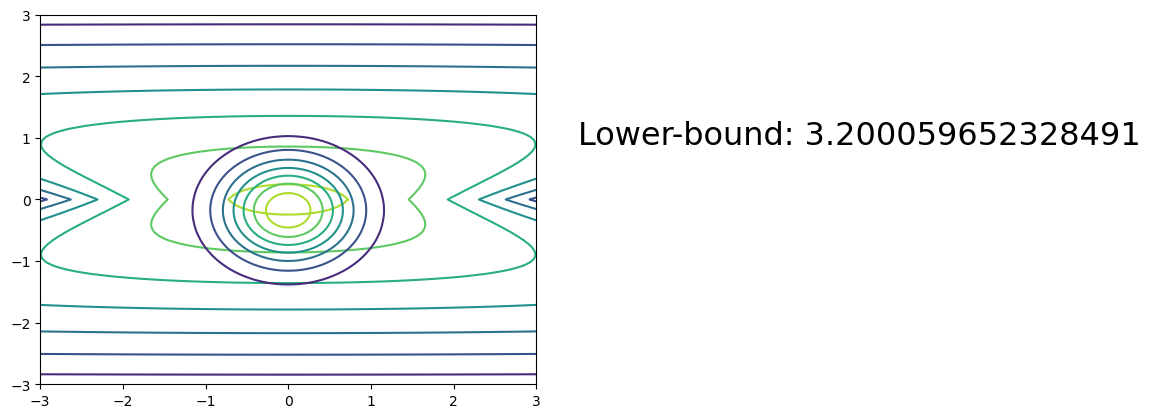

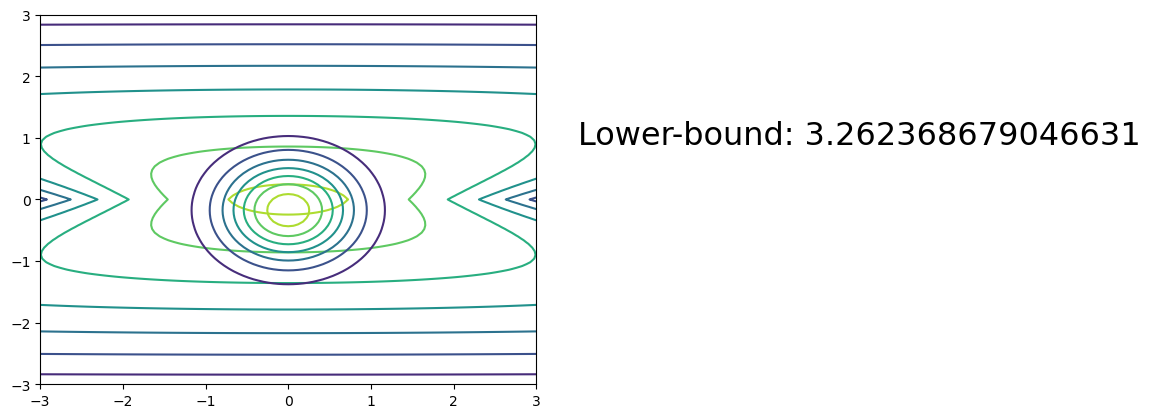

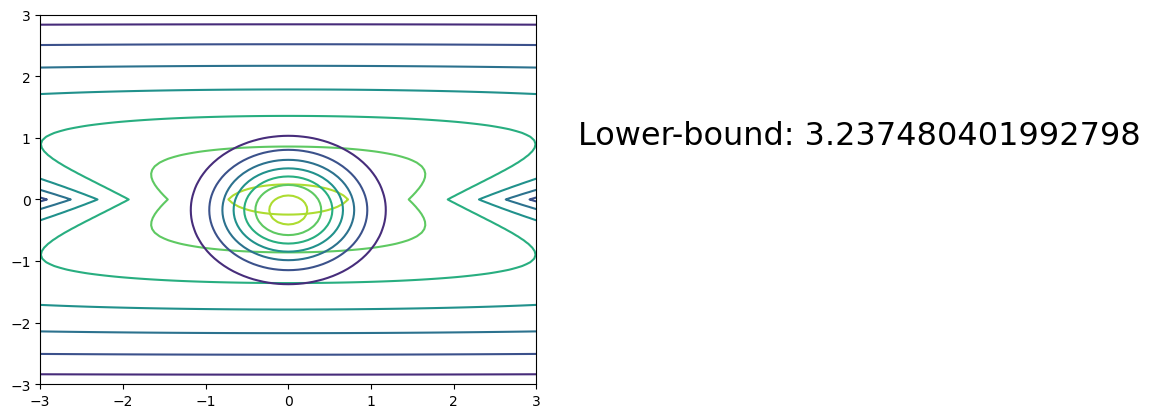

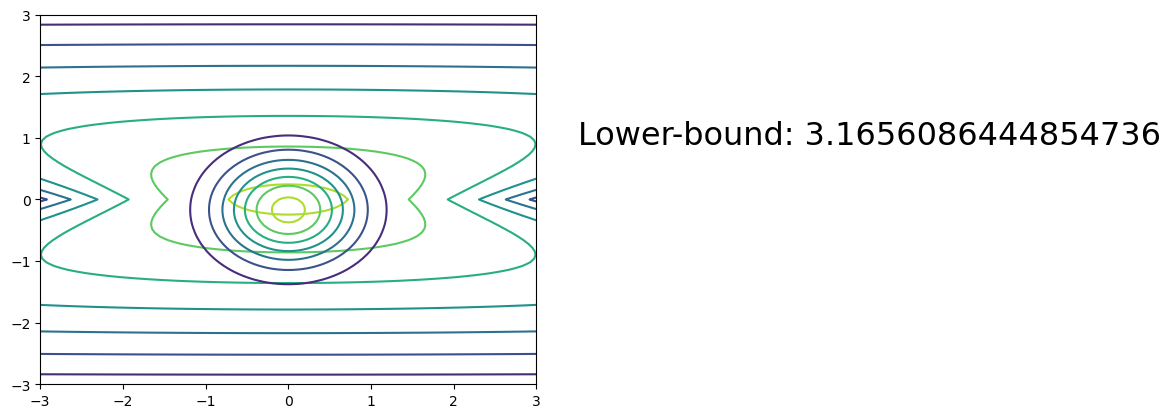

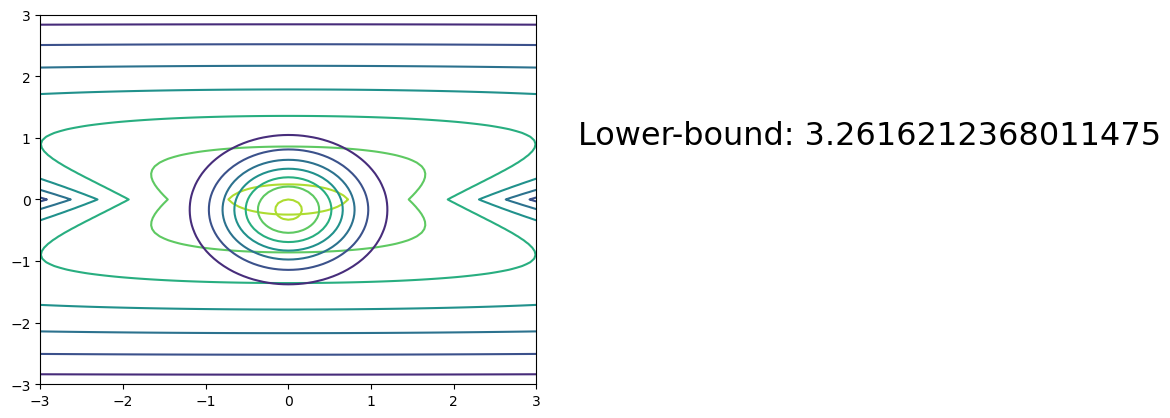

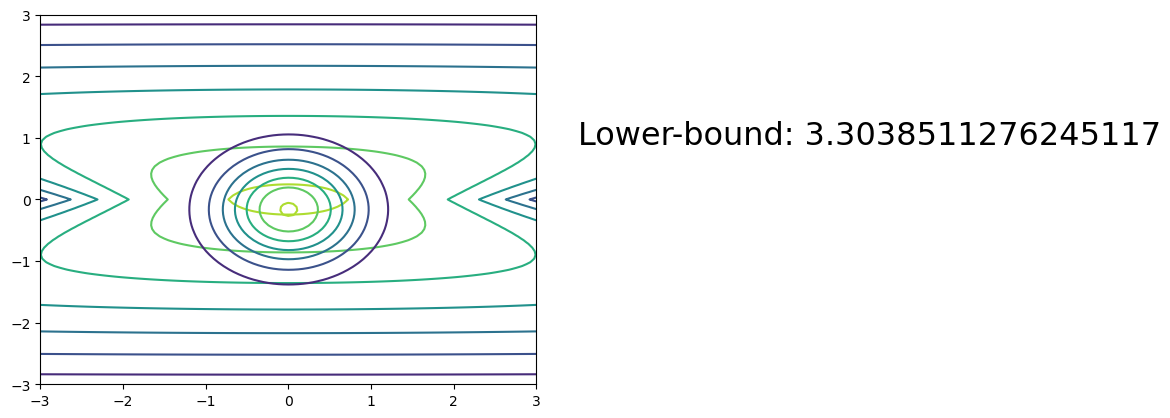

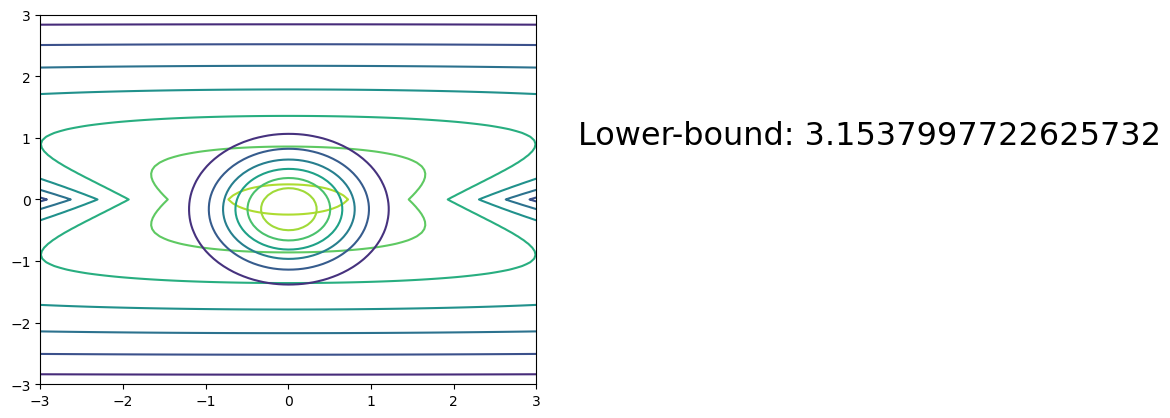

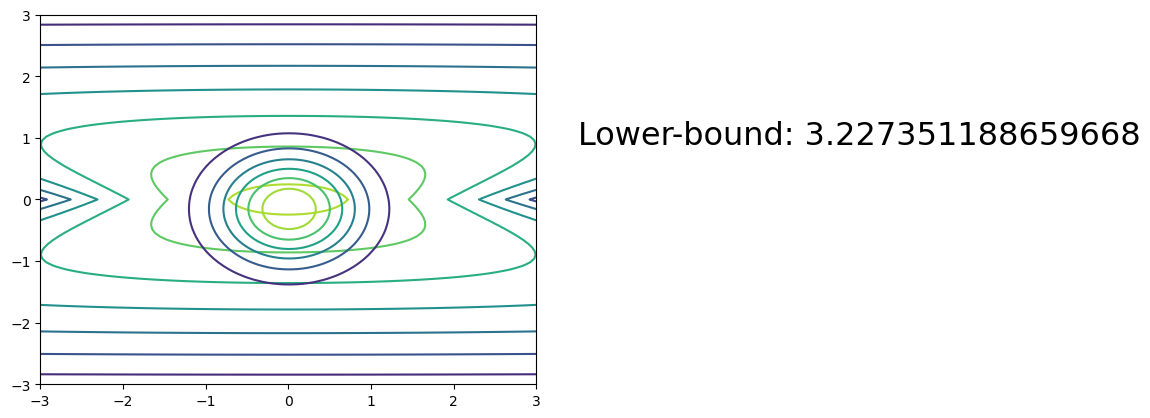

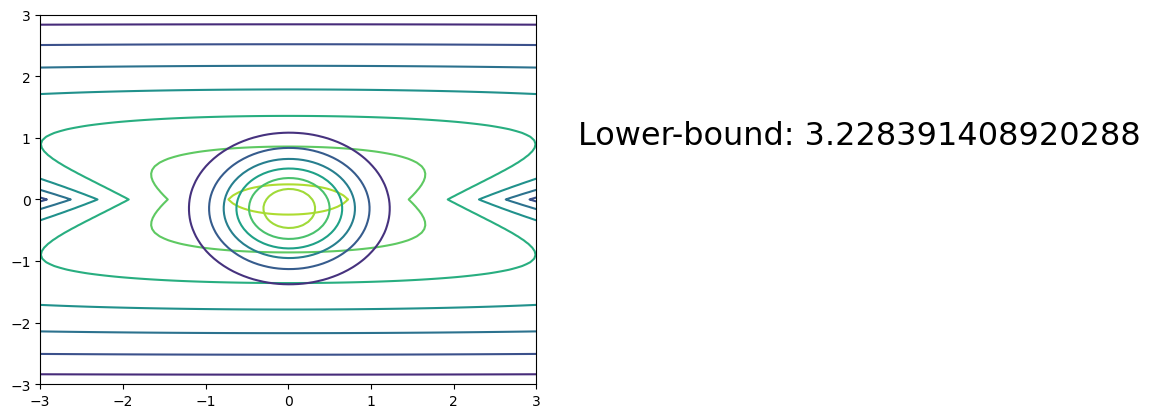

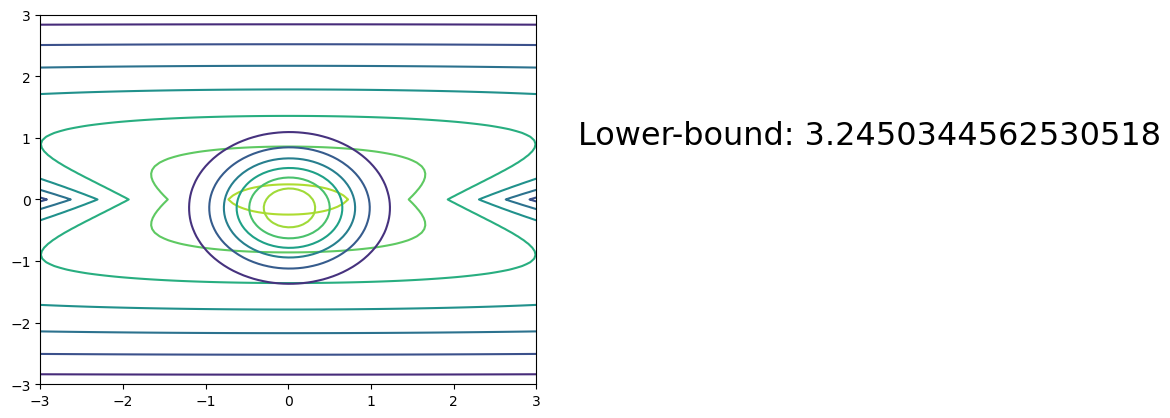

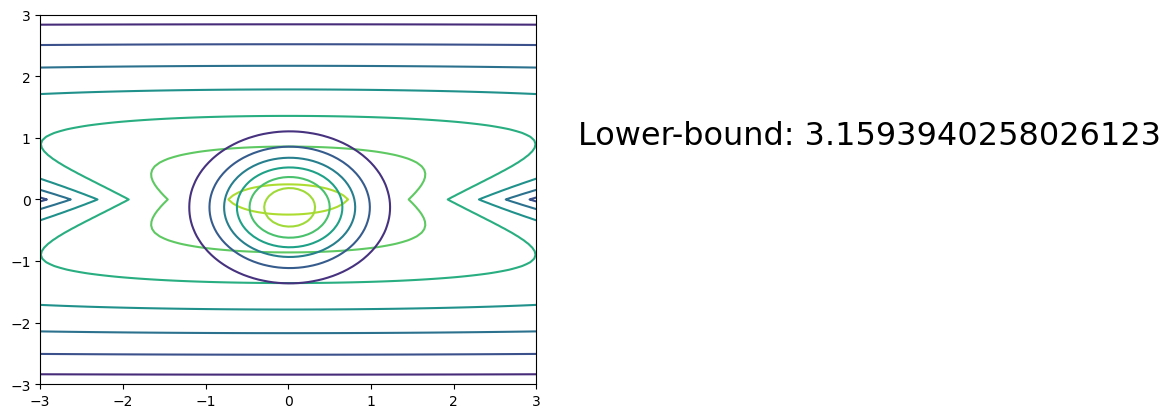

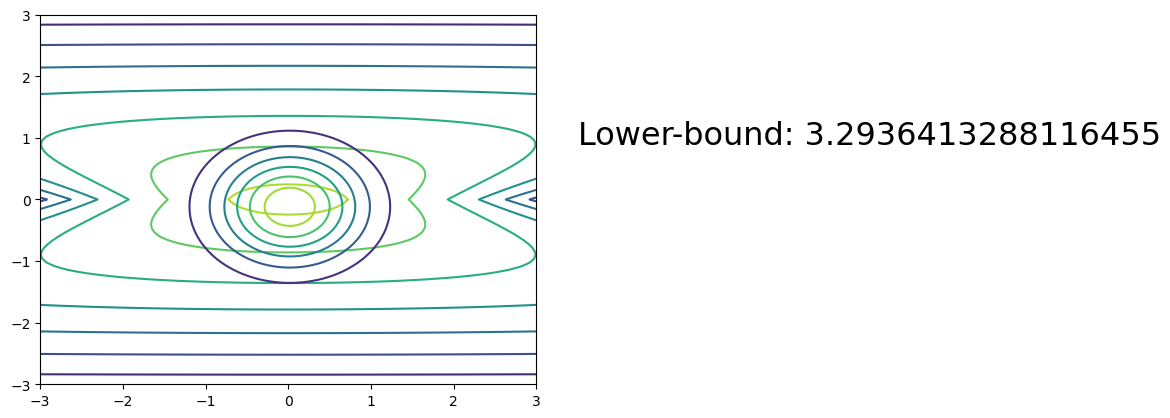

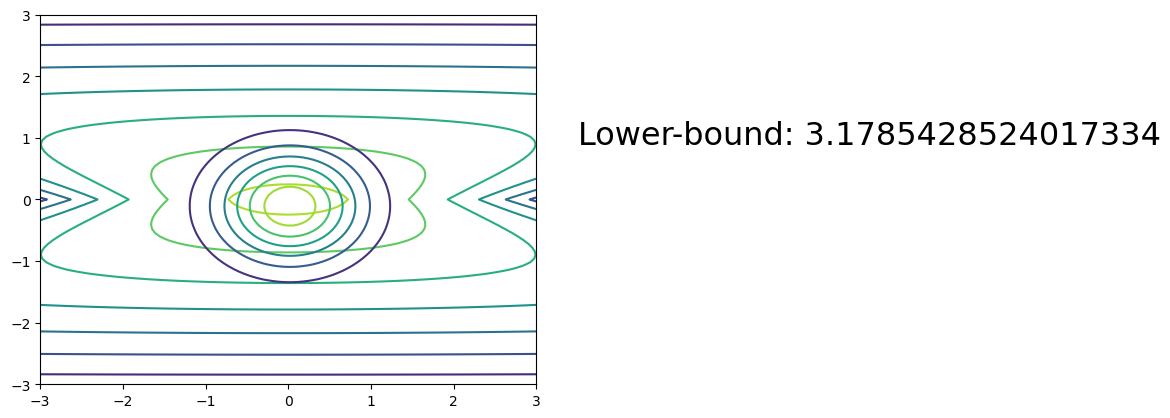

<Figure size 640x480 with 0 Axes>

In [30]:


def black_box_variational_inference(logprob, D, num_samples):
    """Implements http://arxiv.org/abs/1401.0118, and uses the
    local reparameterization trick from http://arxiv.org/abs/1506.02557"""

    def unpack_params(params):
        # Variational dist is a diagonal Gaussian.
        mean, log_std = params[:D], params[D:]
        return mean, log_std

    def gaussian_entropy(log_std):
        # return 0.5 * D * (1.0 + np.log(2*np.pi)) + np.sum(log_std)
        return 0.5 * D * (5.0 + np.log(2*np.pi)) + np.sum(log_std)


    rs = npr.RandomState(0)

    def variational_objective(params, t):
        """Provides a stochastic estimate of the variational lower bound."""
        mean, log_std = unpack_params(params)
        samples = np.array(rs.randn(num_samples, D) * np.exp(log_std) + mean)
        lower_bound = gaussian_entropy(log_std) + np.mean(logprob(samples, t))
        return -lower_bound

    gradient = grad(variational_objective)

    return variational_objective, gradient, unpack_params


if __name__ == '__main__':

    # Specify an inference problem by its unnormalized log-density.
    D = 2

    def log_density(x,t):
        mu, log_sigma = x[:, 0], x[:, 1]
        sigma_density = norm.logpdf(log_sigma, 0, 1.35)
        mu_density = norm.logpdf(mu, 0, np.exp(log_sigma))
        return sigma_density + mu_density

    # Build variational objective.
    objective, gradient, unpack_params = \
        black_box_variational_inference(log_density, D, num_samples=2000)

    # Set up plotting code
    def plot_isocontours(ax, func, xlimits=[-3, 3], ylimits=[-3, 3], numticks=101):
        x = np.linspace(*xlimits, num=numticks)
        y = np.linspace(*ylimits, num=numticks)
        X, Y = np.meshgrid(x, y)
        zs = func(np.concatenate(
            [np.atleast_2d(X.ravel()), np.atleast_2d(Y.ravel())]).T)
        Z = zs.reshape(X.shape)
        plt.contour(X, Y, Z)
        ax.set_yticks([])
        ax.set_xticks([])

    # Set up figure.
    fig = plt.figure(figsize=(8, 8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    plt.ion()
    plt.show(block=False)

    def callback(params, t, g):
        print(f"Iteration {t} lower bound {-objective(params, t)}")

        plt.cla()
        plt.text(3.5, 0.9, f'Lower-bound: {-objective(params, t)}', fontsize = 23)
        def target_distribution(x): 
            """
            The target distribution is the one we want to learn about.
            """
            ret = log_density(np.abs(x), (t))
            print(ret.shape)
            # plt.plot(ret)
            return (ret) 
            # log_density is the log of the target distribution
             
        # def target_distribution(x): return np.sin(log_density(x, t))
        plot_isocontours(ax, target_distribution)

        mean, log_std = unpack_params(params)

        def variational_contour(x): 
            return mvn.pdf(
            x, mean, np.diag(np.exp(2*log_std)))
        plot_isocontours(ax, variational_contour)
        plt.draw()
        plt.figure()

        # plt.savefig(f'./image/s{t:04d}.png')
        # plt.plot()

    print("Optimizing variational parameters...")
    init_mean = -1 * np.ones(D)
    init_log_std = -5 * np.ones(D)
    init_var_params = np.concatenate([init_mean, init_log_std])
    variational_params = adam(
        gradient, init_var_params, step_size=0.1, num_iters=100, callback=callback)


In [6]:
import jax.numpy as jnp
import jax
import distrax
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
key = jax.random.PRNGKey(1234)

2022-11-10 11:19:23.990262: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-10 11:19:24.501503: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/compilers/openmpi/4.1.2/lib64/openmpi:/opt/compilers/openmpi/4.1.2/lib64:/usr/local/cuda/lib64:/opt/compilers/openmpi/4.1.2/lib64/openmpi:/opt/compilers/openmpi/4.1.2/lib64:/usr/local/cuda/lib64:
2022-11-10 11:19:24.501599: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/compilers/openmpi/4.1.2/lib64/openmpi:/opt/compilers/openmpi/4.1.2/lib64:/usr/local/cuda/l

In [19]:
mean = 2
variance  = 3.5
params = mean, variance

target_distribution = tfd.Normal(*params)
target_distribution.sample(seed = key, sample_shape = (10,))

DeviceArray([6.6496334 , 2.7972903 , 0.23258638, 6.855196  , 3.969953  ,
             0.03285074, 3.8335717 , 3.0469313 , 1.9417114 , 5.089579  ],            dtype=float32)

In [20]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# Variational Inference with Coordinate Ascent


In [21]:
import numpy as np


class UGMM(object):
    '''Univariate GMM with CAVI'''

    def __init__(self, X, K=2, sigma=1):
        self.X = X
        self.K = K
        self.N = self.X.shape[0]
        self.sigma2 = sigma**2

    def _init(self):
        self.phi = np.random.dirichlet(
            [np.random.random()*np.random.randint(1, 10)]*self.K, self.N)
        self.m = np.random.randint(int(self.X.min()), high=int(
            self.X.max()), size=self.K).astype(float)
        self.m += self.X.max()*np.random.random(self.K)
        self.s2 = np.ones(self.K) * np.random.random(self.K)
        print('Init mean')
        print(self.m)
        print('Init s2')
        print(self.s2)

    def get_elbo(self):
        t1 = np.log(self.s2) - self.m/self.sigma2
        t1 = t1.sum()
        t2 = -0.5*np.add.outer(self.X**2, self.s2+self.m**2)
        t2 += np.outer(self.X, self.m)
        t2 -= np.log(self.phi)
        t2 *= self.phi
        t2 = t2.sum()
        return t1 + t2

    def fit(self, max_iter=100, tol=1e-10):
        self._init()
        self.elbo_values = [self.get_elbo()]
        self.m_history = [self.m]
        self.s2_history = [self.s2]
        for iter_ in range(1, max_iter+1):
            self._cavi()
            self.m_history.append(self.m)
            self.s2_history.append(self.s2)
            self.elbo_values.append(self.get_elbo())
            if iter_ % 5 == 0:
                print(iter_, self.m_history[iter_])
            if np.abs(self.elbo_values[-2] - self.elbo_values[-1]) <= tol:
                print('ELBO converged with ll %.3f at iteration %d' % (self.elbo_values[-1],
                                                                       iter_))
                break

        if iter_ == max_iter:
            print('ELBO ended with ll %.3f' % (self.elbo_values[-1]))

    def _cavi(self):
        self._update_phi()
        self._update_mu()

    def _update_phi(self):
        t1 = np.outer(self.X, self.m)
        t2 = -(0.5*self.m**2 + 0.5*self.s2)
        exponent = t1 + t2[np.newaxis, :]
        self.phi = np.exp(exponent)
        self.phi = self.phi / self.phi.sum(1)[:, np.newaxis]

    def _update_mu(self):
        self.m = (self.phi*self.X[:, np.newaxis]).sum(0) * \
            (1/self.sigma2 + self.phi.sum(0))**(-1)
        assert self.m.size == self.K
        #print(self.m)
        self.s2 = (1/self.sigma2 + self.phi.sum(0))**(-1)
        assert self.s2.size == self.K


In [22]:
num_components = 3
mu_arr = np.random.choice(np.arange(-10, 10, 2),
                          num_components) +\
    np.random.random(num_components)
mu_arr


array([ 6.63337121, -9.4168184 , -7.35793015])

In [23]:
SAMPLE = 10000


In [24]:
X = np.random.normal(loc=mu_arr[0], scale=1, size=SAMPLE)
for i, mu in enumerate(mu_arr[1:]):
    X = np.append(X, np.random.normal(loc=mu, scale=1, size=SAMPLE))


In [25]:
import seaborn as sns

/tmp/ipykernel_327449/2597608201.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X[:SAMPLE], ax=ax, rug=True)
/tmp/ipykernel_327449/2597608201.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X[SAMPLE:SAMPLE*2], ax=ax, rug=True)
/tmp/ipykernel_327449/2597608201.py:4: UserWarning: 

`distp

<AxesSubplot:ylabel='Density'>

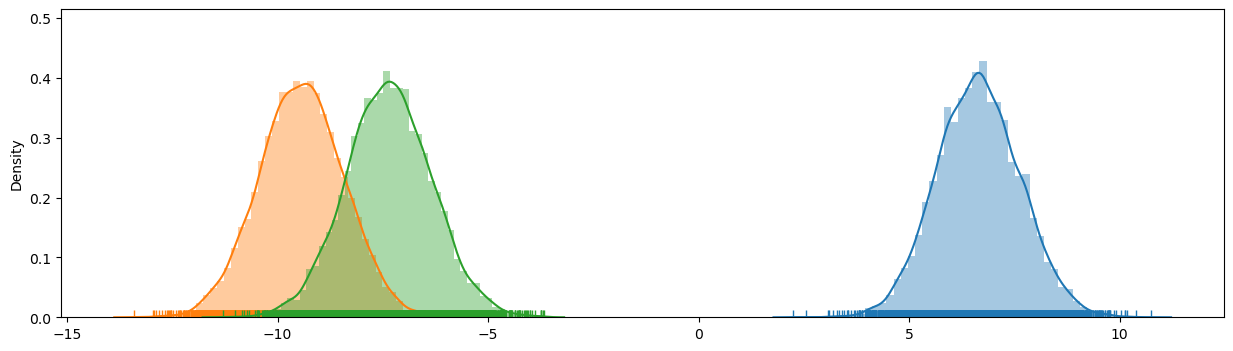

In [26]:
fig, ax = plt.subplots(figsize=(15, 4))
sns.distplot(X[:SAMPLE], ax=ax, rug=True)
sns.distplot(X[SAMPLE:SAMPLE*2], ax=ax, rug=True)
sns.distplot(X[SAMPLE*2:], ax=ax, rug=True)


In [27]:
ugmm = UGMM(X, 3)
ugmm.fit()


Init mean
[8.25506029 1.97686603 3.6540499 ]
Init s2
[0.80800988 0.25743768 0.47818825]
5 [ 6.95727187 -8.39024464  6.33188912]
10 [ 6.85018176 -8.39024464  6.43926713]
15 [ 6.80176204 -8.39024464  6.48769531]
20 [ 6.77221487 -8.39024464  6.51725425]
25 [ 6.75158986 -8.39024464  6.53788817]
30 [ 6.73606153 -8.39024464  6.55342296]
35 [ 6.72379852 -8.39024464  6.56569069]
40 [ 6.71379627 -8.39024464  6.57569646]
45 [ 6.70544935 -8.39024464  6.58404604]
50 [ 6.69836653 -8.39024464  6.59113089]
55 [ 6.69228092 -8.39024464  6.59721808]
60 [ 6.68700228 -8.39024464  6.60249795]
65 [ 6.68239008 -8.39024464  6.60711111]
70 [ 6.67833724 -8.39024464  6.61116472]
75 [ 6.67476005 -8.39024464  6.61474251]
80 [ 6.67159161 -8.39024464  6.61791143]
85 [ 6.66877741 -8.39024464  6.62072601]
90 [ 6.66627234 -8.39024464  6.62323138]
95 [ 6.66403852 -8.39024464  6.62546545]
100 [ 6.66204379 -8.39024464  6.62746039]
ELBO ended with ll -18984.691


In [28]:
sorted(mu_arr)


[-9.416818399536776, -7.35793015271869, 6.63337121196521]

In [29]:
sorted(ugmm.m)


[-8.390244643531755, 6.627460385040797, 6.662043785550687]

In [30]:
SAMPLE

10000

/tmp/ipykernel_327449/1172154031.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X[:SAMPLE], ax=ax, hist=True, norm_hist=True)
/tmp/ipykernel_327449/1172154031.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.random.normal(
/tmp/ipykernel_327449/1172154031.py:6: UserWarning: 


<AxesSubplot:ylabel='Density'>

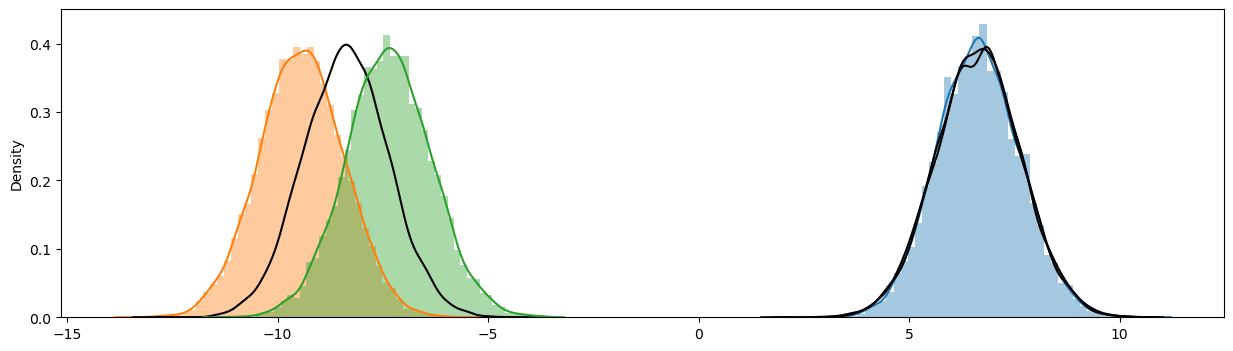

In [31]:
fig, ax = plt.subplots(figsize=(15, 4))
sns.distplot(X[:SAMPLE], ax=ax, hist=True, norm_hist=True)
sns.distplot(np.random.normal(
    ugmm.m[0], 1, SAMPLE), color='k', hist=False, kde=True)

sns.distplot(X[SAMPLE:SAMPLE*2], ax=ax, hist=True, norm_hist=True)
sns.distplot(np.random.normal(
    ugmm.m[1], 1, SAMPLE), color='k', hist=False, kde=True)
sns.distplot(X[SAMPLE*2:], ax=ax, hist=True, norm_hist=True)
sns.distplot(np.random.normal(
    ugmm.m[2], 1, SAMPLE), color='k', hist=False, kde=True)


In [29]:
from __future__ import absolute_import
from __future__ import print_function
import matplotlib.pyplot as plt

import autograd.numpy as np
import autograd.numpy.random as npr
from autograd import value_and_grad
from scipy.optimize import minimize

def build_step_function_dataset(D=1, n_data=40, noise_std=0.1):
    rs = npr.RandomState(0)
    inputs  = np.linspace(-2, 2, num=n_data)
    targets = np.sign(inputs) + rs.randn(n_data) * noise_std
    inputs  = inputs.reshape((len(inputs), D))
    return inputs, targets


def build_deep_gp(input_dimension, hidden_dimension, covariance_function):

    # GP going from input to hidden
    num_params_layer1, predict_layer1, log_marginal_likelihood_layer1 = \
        make_gp_funs(covariance_function, num_cov_params=input_dimension + 1)

    # GP going from hidden to output
    num_params_layer2, predict_layer2, log_marginal_likelihood_layer2 = \
        make_gp_funs(covariance_function, num_cov_params=hidden_dimension + 1)

    num_hidden_params = hidden_dimension * n_data
    total_num_params = num_params_layer1 + num_params_layer2 + num_hidden_params

    def unpack_all_params(all_params):
        layer1_params = all_params[:num_params_layer1]
        layer2_params = all_params[num_params_layer1:num_params_layer1+num_params_layer2]
        hiddens = all_params[num_params_layer1 + num_params_layer2:]
        return layer1_params, layer2_params, hiddens

    def combined_predict_fun(all_params, X, y, xs):
        layer1_params, layer2_params, hiddens = unpack_all_params(all_params)
        h_star_mean, h_star_cov = predict_layer1(layer1_params, X, hiddens, xs)
        y_star_mean, y_star_cov = predict_layer2(layer2_params, np.atleast_2d(hiddens).T, y, np.atleast_2d(h_star_mean).T)
        return y_star_mean, y_star_cov

    def log_marginal_likelihood(all_params):
        layer1_params, layer2_params, h = unpack_all_params(all_params)
        return log_marginal_likelihood_layer1(layer1_params, X, h) + \
               log_marginal_likelihood_layer2(layer2_params, np.atleast_2d(h).T, y)

    predict_layer_funcs = [predict_layer1, predict_layer2]

    return total_num_params, log_marginal_likelihood, combined_predict_fun, unpack_all_params, \
           predict_layer_funcs


if __name__ == '__main__':

    n_data = 20
    input_dimension = 1
    hidden_dimension = 1
    X, y = build_step_function_dataset(D=input_dimension, n_data=n_data)

    total_num_params, log_marginal_likelihood, combined_predict_fun, unpack_all_params, predict_layer_funcs = \
        build_deep_gp(input_dimension, hidden_dimension, rbf_covariance)

    # Set up figure.
    fig = plt.figure(figsize=(12,8), facecolor='white')
    ax_end_to_end = fig.add_subplot(311, frameon=False)
    ax_x_to_h = fig.add_subplot(312, frameon=False)
    ax_h_to_y = fig.add_subplot(313, frameon=False)
    plt.show(block=False)

    def plot_gp(ax, X, y, pred_mean, pred_cov, plot_xs):
        ax.cla()
        marg_std = np.sqrt(np.diag(pred_cov))
        ax.plot(plot_xs, pred_mean, 'b')
        ax.fill(np.concatenate([plot_xs, plot_xs[::-1]]),
                np.concatenate([pred_mean - 1.96 * marg_std,
                               (pred_mean + 1.96 * marg_std)[::-1]]),
                alpha=.15, fc='Blue', ec='None')

        # Show samples from posterior.
        rs = npr.RandomState(0)
        sampled_funcs = rs.multivariate_normal(pred_mean, pred_cov, size=10)
        ax.plot(plot_xs, sampled_funcs.T)
        ax.plot(X, y, 'kx')
        ax.set_ylim([-1.5, 1.5])
        ax.set_xticks([])
        ax.set_yticks([])

    def callback(params):
        print("Log marginal likelihood {}".format(log_marginal_likelihood(params)))

        # Show posterior marginals.
        plot_xs = np.reshape(np.linspace(-5, 5, 300), (300,1))
        pred_mean, pred_cov = combined_predict_fun(params, X, y, plot_xs)
        plot_gp(ax_end_to_end, X, y, pred_mean, pred_cov, plot_xs)
        ax_end_to_end.set_title("X to y")

        layer1_params, layer2_params, hiddens = unpack_all_params(params)
        h_star_mean, h_star_cov = predict_layer_funcs[0](layer1_params, X, hiddens, plot_xs)
        y_star_mean, y_star_cov = predict_layer_funcs[0](layer2_params, np.atleast_2d(hiddens).T, y, plot_xs)

        plot_gp(ax_x_to_h, X, hiddens,                  h_star_mean, h_star_cov, plot_xs)
        ax_x_to_h.set_title("X to hiddens")

        plot_gp(ax_h_to_y, np.atleast_2d(hiddens).T, y, y_star_mean, y_star_cov, plot_xs)
        ax_h_to_y.set_title("hiddens to y")

        plt.draw()
        plt.pause(1.0/60.0)

    # Initialize covariance parameters and hiddens.
    rs = npr.RandomState(0)
    init_params = 0.1 * rs.randn(total_num_params)

    print("Optimizing covariance parameters...")
    objective = lambda params: -log_marginal_likelihood(params)
    cov_params = minimize(value_and_grad(objective), init_params, jac=True,
                          method='CG', callback=callback)
    plt.pause(10.0)

NameError: name 'rbf_covariance' is not defined

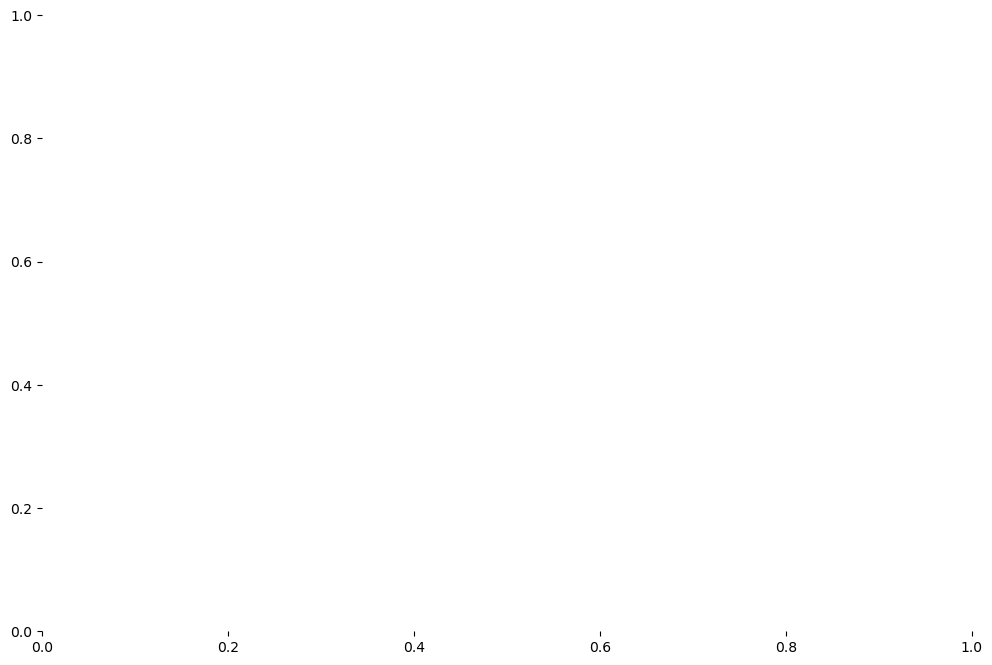

Optimizing covariance parameters...
Log likelihood 9.805252240729983


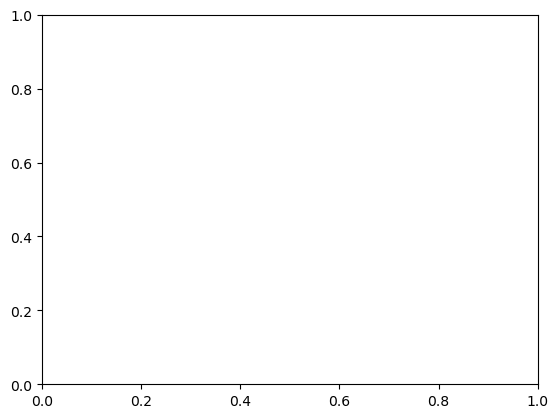

Log likelihood 17.682114335846393


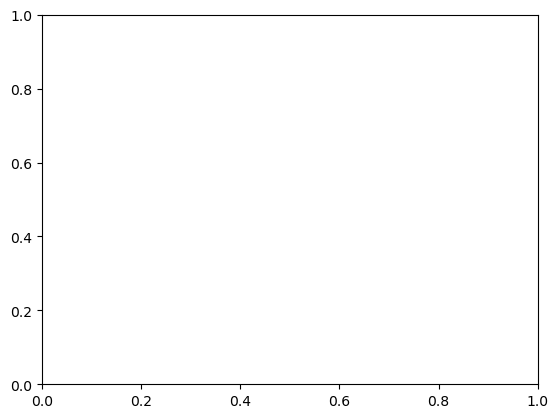

Log likelihood 18.16730523813763


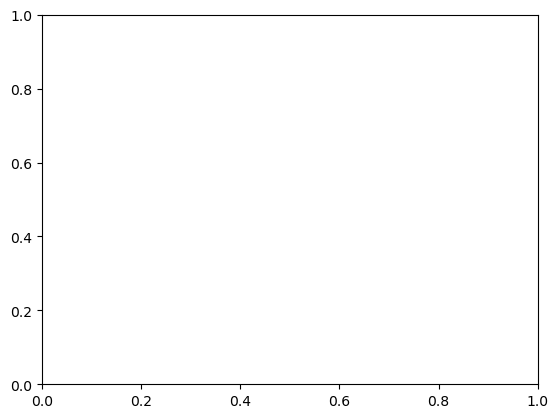

Log likelihood 18.729814009344032


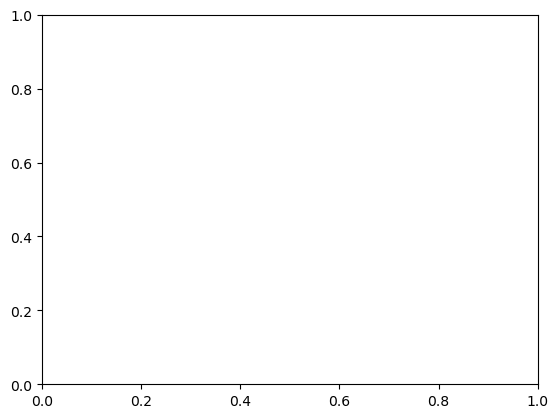

Log likelihood 18.755118594202962


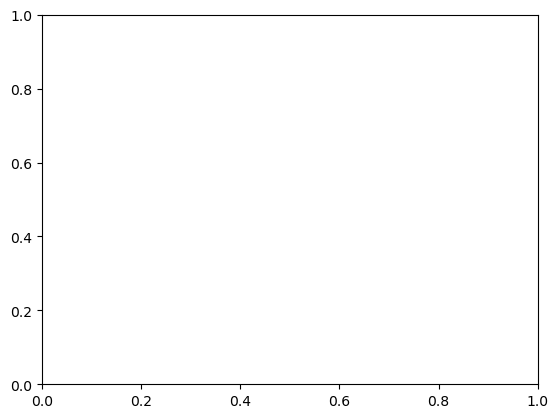

Log likelihood 18.864941820611428


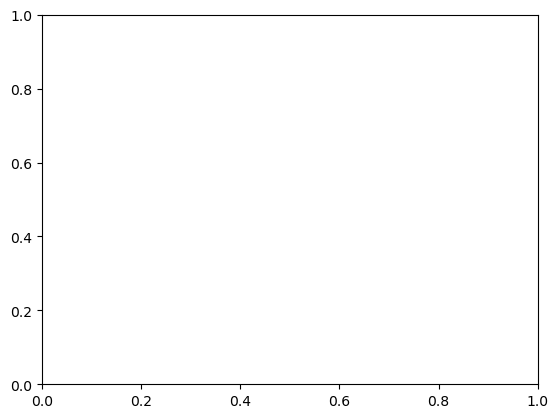

Log likelihood 18.87706078427596


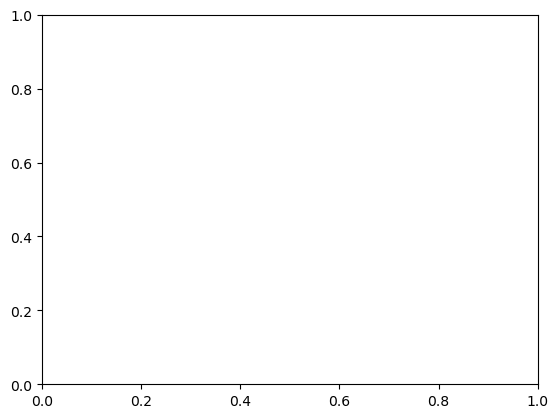

Log likelihood 18.90159165376088


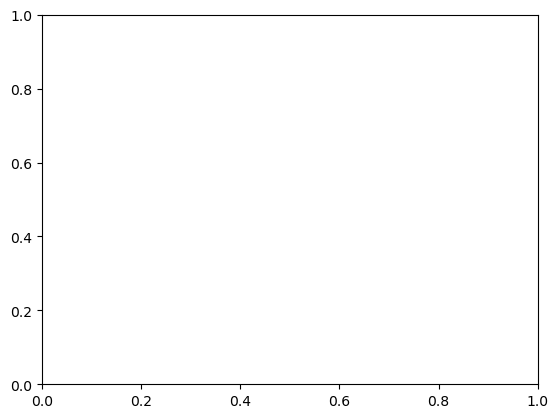

Log likelihood 18.903748881596808


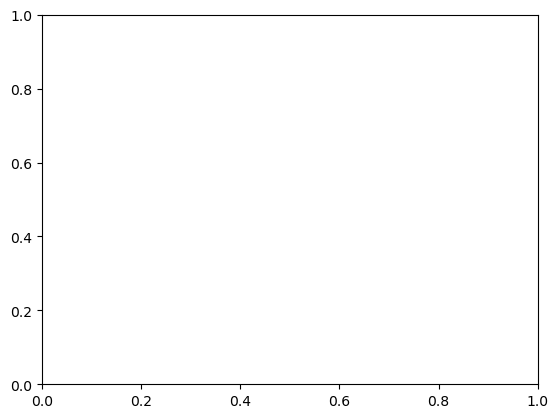

Log likelihood 18.90470342713405


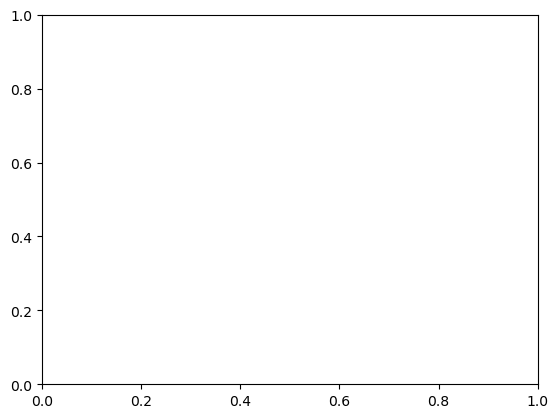

Log likelihood 18.904863126585543


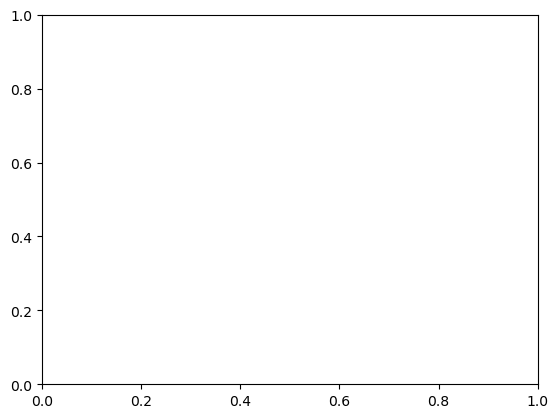

Log likelihood 18.904870536436995


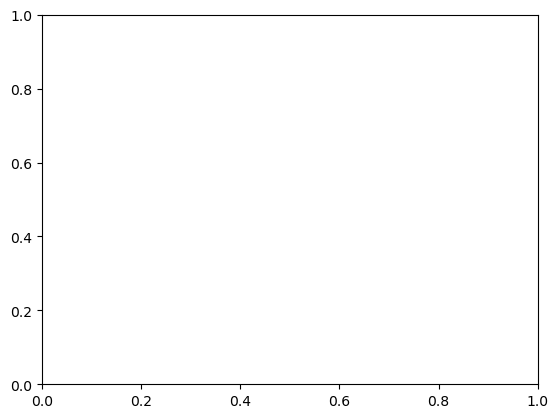

Log likelihood 18.904886849198697


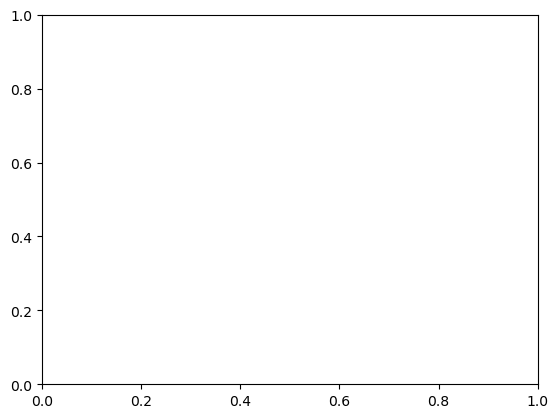

Log likelihood 18.90488995885164


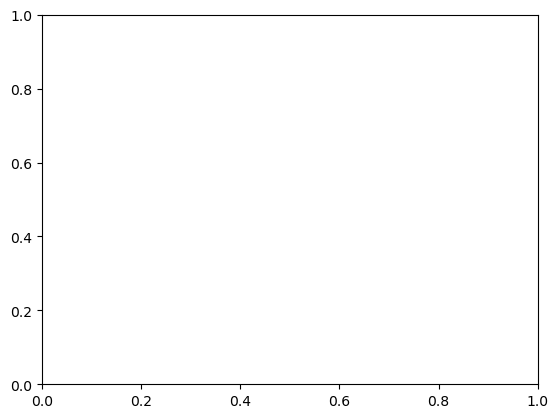

Log likelihood 18.90490471156049


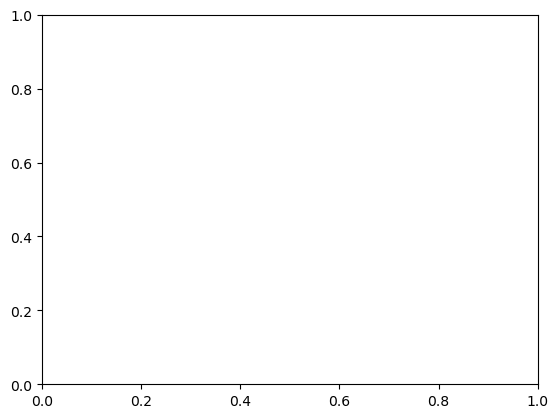

Log likelihood 18.904904716763014


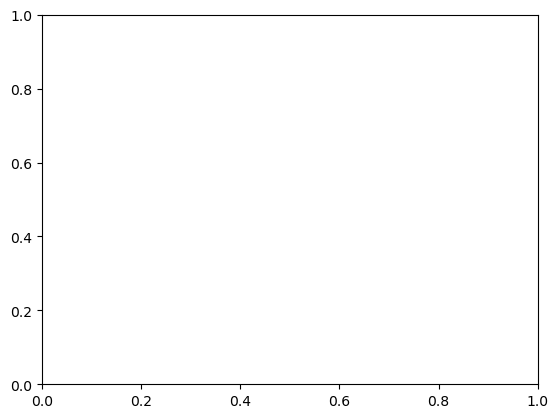

Log likelihood 18.904904717154686


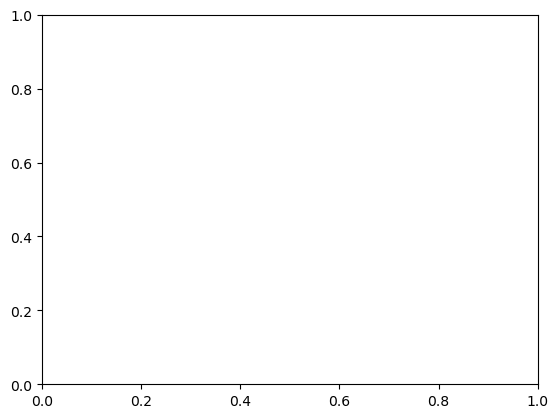

Log likelihood 18.90490471723431


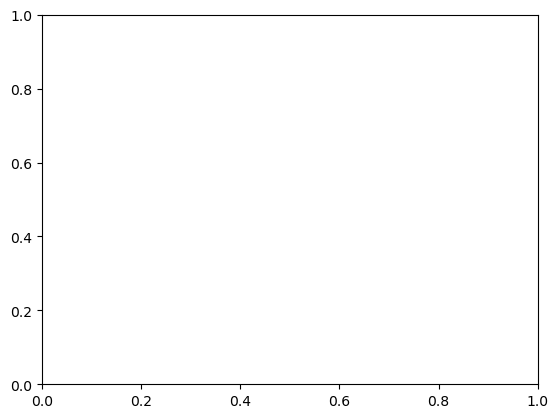

Log likelihood 18.90490471732225


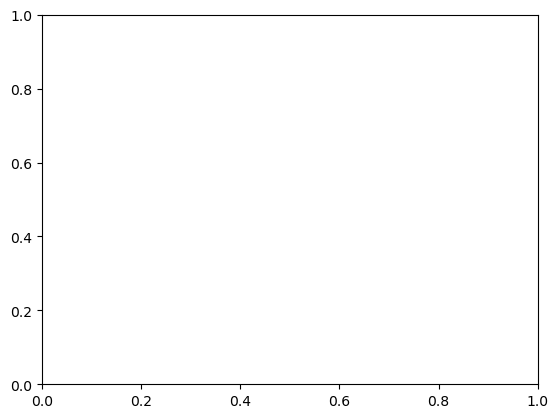

Log likelihood 18.904904717355727


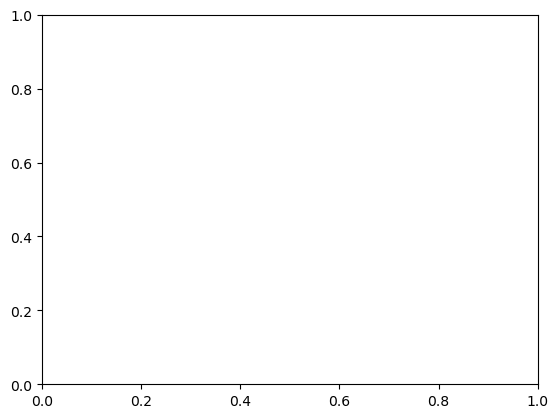

In [36]:
from __future__ import absolute_import
from __future__ import print_function
import matplotlib.pyplot as plt

import autograd.numpy as np
import autograd.numpy.random as npr
from autograd.numpy.linalg import solve
import autograd.scipy.stats.multivariate_normal as mvn
from autograd import value_and_grad
from scipy.optimize import minimize


def make_gp_funs(cov_func, num_cov_params):
    """Functions that perform Gaussian process regression.
       cov_func has signature (cov_params, x, x')"""

    def unpack_kernel_params(params):
        mean = params[0]
        cov_params = params[2:]
        noise_scale = np.exp(params[1]) + 0.0001
        return mean, cov_params, noise_scale

    def predict(params, x, y, xstar):
        """Returns the predictive mean and covariance at locations xstar,
           of the latent function value f (without observation noise)."""
        mean, cov_params, noise_scale = unpack_kernel_params(params)
        cov_f_f = cov_func(cov_params, xstar, xstar)
        cov_y_f = cov_func(cov_params, x, xstar)
        cov_y_y = cov_func(cov_params, x, x) + noise_scale * np.eye(len(y))
        pred_mean = mean + np.dot(solve(cov_y_y, cov_y_f).T, y - mean)
        pred_cov = cov_f_f - np.dot(solve(cov_y_y, cov_y_f).T, cov_y_f)
        return pred_mean, pred_cov

    def log_marginal_likelihood(params, x, y):
        mean, cov_params, noise_scale = unpack_kernel_params(params)
        cov_y_y = cov_func(cov_params, x, x) + noise_scale * np.eye(len(y))
        prior_mean = mean * np.ones(len(y))
        return mvn.logpdf(y, prior_mean, cov_y_y)

    return num_cov_params + 2, predict, log_marginal_likelihood

# Define an example covariance function.


def rbf_covariance(kernel_params, x, xp):
    output_scale = np.exp(kernel_params[0])
    lengthscales = np.exp(kernel_params[1:])
    diffs = np.expand_dims(x / lengthscales, 1)\
        - np.expand_dims(xp/lengthscales, 0)
    return output_scale * np.exp(-0.5 * np.sum(diffs**2, axis=2))


def build_toy_dataset(D=1, n_data=20.0, noise_std=0.1):
    rs = npr.RandomState(0)
    inputs = np.concatenate([np.linspace(0, 3, num=10),
                             np.linspace(6, 8, num=10)])
    targets = (np.cos(inputs) + rs.randn(20) * noise_std) / 2.0
    inputs = (inputs - 4.0) / 2.0
    inputs = inputs.reshape((len(inputs), D))
    return inputs, targets


if __name__ == '__main__':

    D = 1

    # Build model and objective function.
    num_params, predict, log_marginal_likelihood = \
        make_gp_funs(rbf_covariance, num_cov_params=D + 1)

    X, y = build_toy_dataset(D=D)
    def objective(params): return -log_marginal_likelihood(params, X, y)

    # Set up figure.
    fig = plt.figure(figsize=(12, 8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    plt.show(block=False)

    def callback(params):
        print("Log likelihood {}".format(-objective(params)))
        plt.cla()

        # Show posterior marginals.
        plot_xs = np.reshape(np.linspace(-7, 7, 300), (300, 1))
        pred_mean, pred_cov = predict(params, X, y, plot_xs)
        marg_std = np.sqrt(np.diag(pred_cov))
        ax.plot(plot_xs, pred_mean, 'b')
        ax.fill(np.concatenate([plot_xs, plot_xs[::-1]]),
                np.concatenate([pred_mean - 1.96 * marg_std,
                               (pred_mean + 1.96 * marg_std)[::-1]]),
                alpha=.15, fc='Blue', ec='None')

        # Show samples from posterior.
        rs = npr.RandomState(0)
        sampled_funcs = rs.multivariate_normal(pred_mean, pred_cov, size=10)
        ax.plot(plot_xs, sampled_funcs.T)

        ax.plot(X, y, 'kx')
        ax.set_ylim([-1.5, 1.5])
        ax.set_xticks([])
        ax.set_yticks([])
        plt.draw()
        plt.pause(1.0/60.0)

    # Initialize covariance parameters
    rs = npr.RandomState(0)
    init_params = 0.1 * rs.randn(num_params)

    print("Optimizing covariance parameters...")
    cov_params = minimize(value_and_grad(objective), init_params, jac=True,
                          method='CG', callback=callback)
    plt.pause(10.0)


In [21]:
from __future__ import absolute_import
from __future__ import print_function
import matplotlib.pyplot as plt

import autograd.numpy as np
import autograd.numpy.random as npr
from autograd.numpy.linalg import solve
import autograd.scipy.stats.multivariate_normal as mvn
from autograd import value_and_grad
from scipy.optimize import minimize


def make_gp_funs(cov_func, num_cov_params):
    """Functions that perform Gaussian process regression.
       cov_func has signature (cov_params, x, x')"""

    def unpack_kernel_params(params):
        mean = params[0]
        cov_params = params[2:]
        noise_scale = np.exp(params[1]) + 0.0001
        return mean, cov_params, noise_scale

    def predict(params, x, y, xstar):
        """Returns the predictive mean and covariance at locations xstar,
           of the latent function value f (without observation noise)."""
        mean, cov_params, noise_scale = unpack_kernel_params(params)
        cov_f_f = cov_func(cov_params, xstar, xstar)
        cov_y_f = cov_func(cov_params, x, xstar)
        cov_y_y = cov_func(cov_params, x, x) + noise_scale * np.eye(len(y))
        pred_mean = mean + np.dot(solve(cov_y_y, cov_y_f).T, y - mean)
        pred_cov = cov_f_f - np.dot(solve(cov_y_y, cov_y_f).T, cov_y_f)
        return pred_mean, pred_cov

    def log_marginal_likelihood(params, x, y):
        mean, cov_params, noise_scale = unpack_kernel_params(params)
        cov_y_y = cov_func(cov_params, x, x) + noise_scale * np.eye(len(y))
        prior_mean = mean * np.ones(len(y))
        return mvn.logpdf(y, prior_mean, cov_y_y)

    return num_cov_params + 2, predict, log_marginal_likelihood

# Define an example covariance function.


def rbf_covariance(kernel_params, x, xp):
    output_scale = np.exp(kernel_params[0])
    lengthscales = np.exp(kernel_params[1:])
    diffs = np.expand_dims(x / lengthscales, 1)\
        - np.expand_dims(xp/lengthscales, 0)
    return output_scale * np.exp(-0.5 * np.sum(diffs**2, axis=2))


def build_toy_dataset(D=1, n_data=20, noise_std=0.1):
    rs = npr.RandomState(0)
    inputs = np.concatenate([np.linspace(0, 3, num=n_data/2),
                             np.linspace(6, 8, num=n_data/2)])
    targets = (np.cos(inputs) + rs.randn(n_data) * noise_std) / 2.0
    inputs = (inputs - 4.0) / 2.0
    inputs = inputs.reshape((len(inputs), D))
    return inputs, targets


if __name__ == '__main__':

    D = 1

    # Build model and objective function.
    num_params, predict, log_marginal_likelihood = \
        make_gp_funs(rbf_covariance, num_cov_params=D + 1)

    X, y = build_toy_dataset(D=D)
    def objective(params): return -log_marginal_likelihood(params, X, y)

    # Set up figure.
    fig = plt.figure(figsize=(12, 8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    plt.show(block=False)

    def callback(params):
        print("Log likelihood {}".format(-objective(params)))
        plt.cla()

        # Show posterior marginals.
        plot_xs = np.reshape(np.linspace(-7, 7, 300), (300, 1))
        pred_mean, pred_cov = predict(params, X, y, plot_xs)
        marg_std = np.sqrt(np.diag(pred_cov))
        ax.plot(plot_xs, pred_mean, 'b')
        ax.fill(np.concatenate([plot_xs, plot_xs[::-1]]),
                np.concatenate([pred_mean - 1.96 * marg_std,
                               (pred_mean + 1.96 * marg_std)[::-1]]),
                alpha=.15, fc='Blue', ec='None')

        # Show samples from posterior.
        rs = npr.RandomState(0)
        sampled_funcs = rs.multivariate_normal(pred_mean, pred_cov, size=10)
        ax.plot(plot_xs, sampled_funcs.T)

        ax.plot(X, y, 'kx')
        ax.set_ylim([-1.5, 1.5])
        ax.set_xticks([])
        ax.set_yticks([])
        plt.draw()
        plt.pause(1.0/60.0)

    # Initialize covariance parameters
    rs = npr.RandomState(0)
    init_params = 0.1 * rs.randn(num_params)

    print("Optimizing covariance parameters...")
    cov_params = minimize(value_and_grad(objective), init_params, jac=True,
                          method='CG', callback=callback)
    plt.pause(10.0)


TypeError: 'float' object cannot be interpreted as an integer